In [ ]:
#Phase 1 : Normalize the plain text file

# STEP 1: PRE-PROCESSING + CHAPTER DETECTION

# Kafka's *The Trial* — Clean text, remove front matter, and detect chapter boundaries.

# ---------- IMPORTS ----------
import io
import re
import os

# ---------- RAW FILE ----------
RAW_PATH = "1_Orignal_the_trial.txt"   # UTF-8 Project Gutenberg file

# ---------- LOAD RAW TEXT ----------
with io.open(RAW_PATH, "r", encoding="utf-8") as f:
    raw_text = f.read()

# ---------- NORMALIZE NEWLINES ----------
raw_text = raw_text.replace("\r\n", "\n").replace("\r", "\n")

# ---------- STRIP GUTENBERG HEADER / FOOTER ----------
start_pat = r"\*\*\* START OF THE PROJECT GUTENBERG EBOOK.*?\*\*\*"
end_pat   = r"\*\*\* END OF THE PROJECT GUTENBERG EBOOK.*?\*\*\*"
start_match = re.search(start_pat, raw_text, flags=re.IGNORECASE | re.DOTALL)
end_match   = re.search(end_pat,   raw_text, flags=re.IGNORECASE | re.DOTALL)
main_text = raw_text[start_match.end():end_match.start()] if (start_match and end_match) else raw_text

# ---------- KEEP ONLY FROM FIRST "CHAPTER" ----------
first_chapter_re = re.compile(r"(?im)^\s*Chapter\s+[A-Za-z]+\b.*$", re.MULTILINE)
first_chapter_match = first_chapter_re.search(main_text)
chapters_only = main_text[first_chapter_match.start():] if first_chapter_match else main_text

# ---------- CHAPTER DETECTION ----------
# We mark chapters using a multiline regex anchored to line starts.
#   ^ + re.MULTILINE  → match at the start of any line
#   \s*               → tolerates leading spaces
#   ([A-Za-z]+)       → captures “One”, “Two”, etc.
chapter_pattern = re.compile(r"(?im)^\s*Chapter\s+([A-Za-z]+)\s*$", re.MULTILINE)
chap_matches = list(chapter_pattern.finditer(chapters_only))

chapters = []
if chap_matches:
    for i, m in enumerate(chap_matches):
        start = m.start()
        end = chap_matches[i+1].start() if i + 1 < len(chap_matches) else len(chapters_only)
        title = m.group(0).strip()
        content = chapters_only[start:end].strip()
        chapters.append((title, content))
else:
    # fallback: treat entire text as one chapter if none detected
    chapters = [("Chapter Unknown", chapters_only.strip())]

# ---------- SAVE CLEAN TEXT ----------
CLEAN_PATH = "2_Chapters_the_trial.txt"
with io.open(CLEAN_PATH, "w", encoding="utf-8") as f:
    f.write(chapters_only)

# ---------- PRINT BASIC STATS ----------
print("✅ Preprocessing complete!")
print(f"Total characters: {len(raw_text):,}")
print(f"Main body characters (after trimming): {len(main_text):,}")
print(f"Chapters detected: {len(chapters)}")
print(f"Saved cleaned chapters-only file → {os.path.abspath(CLEAN_PATH)}")

# Optional: show first few chapter titles
print("\nDetected Chapter Headers:")
for i, (title, _) in enumerate(chapters[:10], start=1):
    print(f"{i:>2}. {title}")

✅ Preprocessing complete!
Total characters: 469,532
Main body characters (after trimming): 449,779
Chapters detected: 10
Saved cleaned chapters-only file → /Users/shikha/Desktop/MTL RESEARCH/2_Chapters_the_trial.txt

Detected Chapter Headers:
 1. Chapter One
 2. Chapter Two
 3. Chapter Three
 4. Chapter Four
 5. Chapter Five
 6. Chapter Six
 7. Chapter Seven
 8. Chapter Eight
 9. Chapter Nine
10. Chapter Ten


In [48]:
# PHASE 1: STEP 2 : NAME/ROLE NORMALIZATION
# 
# STEP 2: NORMALIZATION RULES after CLOSE READING OF THE TRIAL
# -----------------------------------------------
import re

# ---------- Protagonist folding: Josef/Joseph → K. ----------
PROTAGONIST_PATTERNS = [
    (r"\bJosef\s+K\.\s*['’]s\b", "K.'s"),
    (r"\bJoseph\s+K\.\s*['’]s\b", "K.'s"),
    (r"\bJosef\s+K\.\b", "K."),
    (r"\bJoseph\s+K\.\b", "K."),
    (r"\bJosef\s+K\b", "K."),
    (r"\bJoseph\s+K\b", "K."),
]

# ---------- Context-first rules (precision first) ----------
CONTEXT_RULES = [
    # K.'s uncle → Uncle_Karl
    (r"(?i)\bK\.\s*['’]s\s+uncle\b", "Uncle_Karl"),
    # "Uncle Karl" → Uncle_Karl
    (r"(?i)\bUncle\s+Karl\b", "Uncle_Karl"),
    # “Block, the businessman” → Block_Client
    (r"(?i)\bBlock,\s+the\s+business\s*-?\s*man\b", "Block_Client"),
    # “the businessman Block” → Block_Client
    (r"(?i)\b(?:the\s+)?business\s*-?\s*man\s+Block\b", "Block_Client"),
    # possessives too
    (r"(?i)\b(?:business\s*-?\s*man)\s+Block['’]s\b", "Block_Client"),
]

# ---------- Case-insensitive name/role canonicalization ----------
NAME_MAP_CI = {
    # Named persons
    r"\bMrs\.?\s+Grubach\b": "Mrs_Grubach",
    r"\bFrau\s+Grubach\b": "Mrs_Grubach",
    r"\bMiss\s+B[üu]rstner\b": "Miss_Buerstner",
    r"\bFr[äa]ulein\s+B[üu]rstner\b": "Miss_Buerstner",
    r"\bFranz\b": "Franz_Warder",
    r"\bWillem\b": "Willem_Warder",

    # Court officials
    r"\bExamining\s+Magistrate\b": "Examining_Magistrate",
    r"\bInvestigating\s+Judge\b": "Examining_Magistrate",
    r"\bSupervisor\b": "Supervisor",
    r"\bUsher\b": "Usher",

    # Lawyer Huld variants → huld_lawyer
    r"\bLawyer\s+Huld\b": "huld_lawyer",
    r"\bAdvocate\s+Huld\b": "huld_lawyer",
    r"\bthe\s+lawyer\b": "huld_lawyer",
    r"\bHuld\b": "huld_lawyer",

    # Leni / carer
    r"\bLeni\b": "Leni",
    r"\bthe\s+carer\b": "Leni",
    r"\bcarer\b": "Leni",

    # Painter → Titorelli
    r"\bTitorelli\b": "Titorelli",
    r"\bthe\s+painter\b": "Titorelli",
    r"\bpainter\b": "Titorelli",

    # Priest/Chaplain
    r"\bChaplain\b": "Prison_Chaplain",

    # Uncle (generic)
    r"\bUncle\b": "Uncle_Karl",

    # Block family and related mappings
    r"\bRudi\b": "Block_Client",
    r"\bBlock\b": "Block_Client",
    r"\bbusiness\s*-?\s*man\b": "Block_Client",

    # Washerwoman + Usher's wife unified
    r"\bUsher['’]s\s+wife\b": "Ushers_Wife",
    r"\bthe\s+washerwoman\b": "Ushers_Wife",
    r"\bwasherwoman\b": "Ushers_Wife",

    # Remaining minor characters
    r"\bRabensteiner\b": "Rabensteiner",
    r"\bKullich\b": "Kullich",
    r"\bKaminer\b": "Kaminer",
}

# ---------- Case-sensitive institutional tokens ----------
NAME_MAP_CS = {
    r"\bCourt\b": "Court_Institution",
    r"\bJudge\b": "Judge_Generic",
}

# ---------- Apply Normalization ----------
def apply_normalization(s: str) -> str:
    """Apply canonical name/role normalization in correct order."""
    s = s.replace("’", "'")  # unify curly apostrophes

    # 1) Context rules first (precision)
    for pat, repl in CONTEXT_RULES:
        s = re.sub(pat, repl, s, flags=re.IGNORECASE)

    # 2) Protagonist folding
    for pat, repl in PROTAGONIST_PATTERNS:
        s = re.sub(pat, repl, s, flags=re.IGNORECASE)

    # 3) Case-insensitive name maps
    for pat, repl in NAME_MAP_CI.items():
        s = re.sub(pat, repl, s, flags=re.IGNORECASE)

    # 4) Case-sensitive institutional tokens
    for pat, repl in NAME_MAP_CS.items():
        s = re.sub(pat, repl, s)

    return s

In [55]:
# Phase 1: STEP 3: FINAL NORMALIZATION + SURFACE CLEANUP + SAVE

# STEP 3: APPLY NORMALIZATION (per chapter) + SURFACE CLEANUP + SAVE (single final file)
# --------------------------------------------------------------------------------------
import io, os  # os not strictly needed now, but harmless if elsewhere you use it
from pathlib import Path
import re, unicodedata

# (assumes `apply_normalization`, PROTAGONIST_PATTERNS, CONTEXT_RULES,
#  NAME_MAP_CI, NAME_MAP_CS, and `chapters` are already defined above)

def sub_ci(pat, repl, s):
    return re.sub(pat, repl, s, flags=re.IGNORECASE)

def sub_cs(pat, repl, s):
    return re.sub(pat, repl, s)

# --------------------
# 3A) Entity normalization per chapter (in-memory)
# --------------------
norm_chapters = []
for title, content in chapters:
    t = content

    # Single, authoritative pass:
    # CONTEXT_RULES → PROTAGONIST_PATTERNS → NAME_MAP_CI → NAME_MAP_CS
    t = apply_normalization(t)

    # Gutenberg-style emphasis underscores at word edges ONLY
    t = re.sub(r"(^|\s)_+([A-Za-z]+(?:'[A-Za-z]+)?)_+(\s|$|[.,;:!?])", r"\1\2\3", t)
    t = re.sub(r"(^|\s)_+([A-Za-z]+(?:'[A-Za-z]+)?)",                r"\1\2",    t)
    t = re.sub(r"([A-Za-z]+(?:'[A-Za-z]+)?)_+(\s|$|[.,;:!?])",       r"\1\2",    t)
    t = re.sub(r"(^|\s)_(?=\s|$|[.,;:!?])",                          r"\1",      t)
    t = re.sub(r"__+", "_", t)

    # Punctuation hygiene around K.
    t = re.sub(r"\bK\.\s+([,\.;:!?\)])", r"K.\1", t)  # "K. ," -> "K.,"
    t = re.sub(r"\bK\.\.+", "K.", t)                 # "K.."  -> "K."
    t = re.sub(r"\bK\.’s\b", "K.'s", t)              # unify curly apostrophe

    norm_chapters.append((title, t))

# Join chapters → one normalized string (no file written yet)
normalized_text = "\n\n".join(ct for _, ct in norm_chapters)

# --------------------
# 3B) Surface cleanup on the normalized string (in-memory)
# --------------------
txt = normalized_text

# Unicode normalization (compose accents into NFC)
txt = unicodedata.normalize("NFC", txt)

# Normalize line endings; collapse hard-wrapped lines within paragraphs
txt = txt.replace("\r\n", "\n").replace("\r", "\n")

# Paragraphs = split on blank lines; join intra-paragraph newlines to spaces
paras = txt.split("\n\n")
paras = [re.sub(r"\s*\n\s*", " ", p).strip() for p in paras if p.strip()]
txt = "\n\n".join(paras)

# Standardize dashes (ASCII "--" → em dash with spacing)
txt = re.sub(r"\s*--\s*", " — ", txt)

# Underscores handling (you already removed Gutenberg _emphasis_; leave internals by default)
KEEP_UNDERSCORES = True
if not KEEP_UNDERSCORES:
    txt = re.sub(r"(?<=\w)_(?=\w)", " ", txt)

# Ellipses and whitespace around punctuation
txt = re.sub(r"\.\s*\.\s*\.", "…", txt)                 # three dots -> ellipsis
txt = re.sub(r"[ \t]+", " ", txt)                       # collapse multiple spaces
txt = re.sub(r"\s+([,.;:!?…—)])", r"\1", txt)           # trim space before closers
txt = re.sub(r"([(\[«])\s+", r"\1", txt)                # trim space after openers

# (Optional) ensure a space after sentence end if missing:
# txt = re.sub(r"([.!?])([A-Za-z])", r"\1 \2", txt)

# --------------------
# 3C) Write the single FINAL normalized file
# --------------------
FINAL_PATH = "3_Final_normalized_the_trial.txt"
Path(FINAL_PATH).write_text(txt, encoding="utf-8")
print(f"✅ Wrote final normalized text → {Path(FINAL_PATH).resolve()}")

✅ Wrote final normalized text → /Users/shikha/Desktop/MTL RESEARCH/3_Final_normalized_the_trial.txt


In [56]:
#Phase 1 complete!

In [17]:
# PHASE 2: Load normalized text → split chapters → basic stats/plots
# ----------------------------------------------------------------
# Requirements:
#   pip install pandas matplotlib
#
# Input:
#   3_Final_normalized_the_trial.txt
#
# Outputs:
#   out/chapters_basic_stats.csv
#   (plots: word and character counts per chapter)

import re
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# --- Files & dirs ---
INPUT = Path("3_Final_normalized_the_trial.txt")
OUT   = Path("out"); OUT.mkdir(exist_ok=True)

# --- Read text & normalize line endings ---
text = INPUT.read_text(encoding="utf-8").replace("\r\n", "\n").replace("\r", "\n")

# --- Robust chapter header pattern ---
# Matches Chapter One / CHAPTER I / Chapter 1 / with subtitles
chap_re = re.compile(r"(?im)^\s*chapter\s+([A-Za-z]+|[IVXLCDM]+|\d+)(?:[^\n]*)$", re.MULTILINE)
matches = list(chap_re.finditer(text))

chapters = []
if matches:
    for i, m in enumerate(matches):
        start = m.start()
        end   = matches[i+1].start() if i+1 < len(matches) else len(text)
        header_line = m.group(0).strip()
        # Content starts after the header’s newline
        header_end = text.find("\n", start)
        content = text[header_end+1:end].strip() if header_end != -1 else text[start:end].strip()
        chapters.append((i+1, header_line, content))
else:
    chapters = [(1, "Chapter 1", text.strip())]

# --- DataFrame ---
df = pd.DataFrame(chapters, columns=["chapter", "chapter_title", "text"])

# --- Compute word and character counts ---
word_pat = re.compile(r"\b\w+\b")
df["word_count"] = df["text"].apply(lambda s: len(word_pat.findall(s)))
df["char_count"] = df["text"].str.len()

# --- Save stats ---
df[["chapter", "chapter_title", "word_count", "char_count"]].to_csv(
    OUT / "chapters_basic_stats.csv", index=False
)

print("✅ Wrote stats to:", (OUT / "chapters_basic_stats.csv").resolve())
print(df[["chapter", "chapter_title", "word_count", "char_count"]])

import plotly.express as px

labels = df["chapter_title"].str.replace(r"(?i)^\s*chapter\s*", "", regex=True)

fig = px.bar(
    df,
    x=labels,
    y="word_count",
    labels={"x": "Chapter", "word_count": "Word Count"},
    title="Word Count per Chapter — Kafka's The Trial",
    color_discrete_sequence=["purple"]  # 👈 all bars purple
)

fig.update_layout(
    xaxis_tickangle=-45,
    template="plotly_white"
)

fig.update_yaxes(tickformat=",d")  # keep your nice thousands formatting
fig.show()

✅ Wrote stats to: /Users/shikha/Desktop/MTL RESEARCH/out/chapters_basic_stats.csv
   chapter  chapter_title  word_count  char_count
0        1    Chapter One       11461       59668
1        2    Chapter Two        6507       34509
2        3  Chapter Three        9805       49811
3        4   Chapter Four        2981       15857
4        5   Chapter Five        2803       14591
5        6    Chapter Six        8429       44254
6        7  Chapter Seven       20142      107479
7        8  Chapter Eight       12151       64454
8        9   Chapter Nine        9375       48741
9       10    Chapter Ten        2125       11182


In [58]:
# PHASE 2.1 — spaCy Tokenization → DataFrames (sentences & tokens)
# ----------------------------------------------------------------
# Requirements:
#   pip install spacy pandas pyarrow
#   python -m spacy download en_core_web_sm
#
# Inputs:
#   3_Final_normalized_the_trial.txt
#
# Outputs:
#   data/sentences.csv
#   data/tokens.parquet

import re
from pathlib import Path
import pandas as pd
import spacy

# --- Paths ---
INPUT = Path("3_Final_normalized_the_trial.txt")
OUTDIR = Path("data"); OUTDIR.mkdir(exist_ok=True)

# --- 1) Read text ---
text = INPUT.read_text(encoding="utf-8").replace("\r\n","\n").replace("\r","\n")

# --- 2) Split into chapters ---
chap_pat = re.compile(r"(?im)^\s*Chapter\s+[A-Za-z]+\s*$", re.MULTILINE)
matches  = list(chap_pat.finditer(text))

chapters = []
if matches:
    for i, m in enumerate(matches):
        start = m.start()
        end   = matches[i+1].start() if i+1 < len(matches) else len(text)
        header = m.group(0).strip()
        # content begins after the header line
        header_end = text.find("\n", start)
        content = text[header_end+1:end].strip() if header_end != -1 else text[start:end].strip()
        chapters.append((i+1, header, content))
else:
    chapters = [(1, "Chapter One", text.strip())]

# --- 3) Run spaCy NLP (tokenize, POS, lemma, sentence splitting) ---
nlp = spacy.load("en_core_web_sm")

sent_rows = []
tok_rows  = []

for chap_idx, chap_title, chap_text in chapters:
    doc = nlp(chap_text)
    for s_i, sent in enumerate(doc.sents, start=1):
        sent_rows.append({
            "chapter": chap_idx,
            "chapter_title": chap_title,
            "sent_id": s_i,
            "text": sent.text.strip()
        })
        for t in sent:
            tok_rows.append({
                "chapter": chap_idx,
                "sent_id": s_i,
                "token": t.text,
                "lemma": t.lemma_,
                "pos": t.pos_,      # coarse POS tag
                "tag": t.tag_,      # fine-grained POS tag
                "dep": t.dep_,      # dependency label
                "head": t.head.text,
                "is_alpha": t.is_alpha,
                "is_stop": t.is_stop
            })

# --- 4) Build DataFrames ---
df_sents = pd.DataFrame(sent_rows)
df_toks  = pd.DataFrame(tok_rows)

# --- 5) Save outputs ---
df_sents.to_csv(OUTDIR / "sentences.csv", index=False)
df_toks.to_parquet(OUTDIR / "tokens.parquet", index=False)

print("✅ Built DataFrames:")
print("  • sentences.csv  →", (OUTDIR / "sentences.csv").resolve())
print("  • tokens.parquet →", (OUTDIR / "tokens.parquet").resolve())

# --- 6) Quick preview ---
print("\nSentences preview:")
print(df_sents.head(5))
print("\nTokens preview:")
print(df_toks.head(10))

✅ Built DataFrames:
  • sentences.csv  → /Users/shikha/Desktop/MTL RESEARCH/data/sentences.csv
  • tokens.parquet → /Users/shikha/Desktop/MTL RESEARCH/data/tokens.parquet

Sentences preview:
   chapter chapter_title  sent_id  \
0        1   Chapter One        1   
1        1   Chapter One        2   
2        1   Chapter One        3   
3        1   Chapter One        4   
4        1   Chapter One        5   

                                                text  
0  Arrest— Conversation with Mrs_Grubach— Then Mi...  
1  Every day at eight in the morning he was broug...  
2                    That had never happened before.  
3  K. waited a little while, looked from his pill...  
4  There was immediately a knock at the door and ...  

Tokens preview:
   chapter  sent_id           token           lemma    pos  tag     dep  \
0        1        1          Arrest          arrest   VERB   VB     dep   
1        1        1               —               —  PUNCT    :   punct   
2        1    

In [59]:
# --- 5) Save outputs (Parquet + CSV mirror) ---
df_sents.to_csv(OUTDIR / "sentences.csv", index=False)
df_toks.to_parquet(OUTDIR / "tokens.parquet", index=False)

# ALSO save a CSV copy to your Desktop research folder
csv_path = Path("/Users/shikha/Desktop/MTL RESEARCH/data/tokens.csv")
csv_path.parent.mkdir(parents=True, exist_ok=True)
df_toks.to_csv(csv_path, index=False)

print("✅ Built DataFrames:")
print("  • sentences.csv  →", (OUTDIR / "sentences.csv").resolve())
print("  • tokens.parquet →", (OUTDIR / "tokens.parquet").resolve())
print("  • tokens.csv     →", csv_path.resolve())

✅ Built DataFrames:
  • sentences.csv  → /Users/shikha/Desktop/MTL RESEARCH/data/sentences.csv
  • tokens.parquet → /Users/shikha/Desktop/MTL RESEARCH/data/tokens.parquet
  • tokens.csv     → /Users/shikha/Desktop/MTL RESEARCH/data/tokens.csv


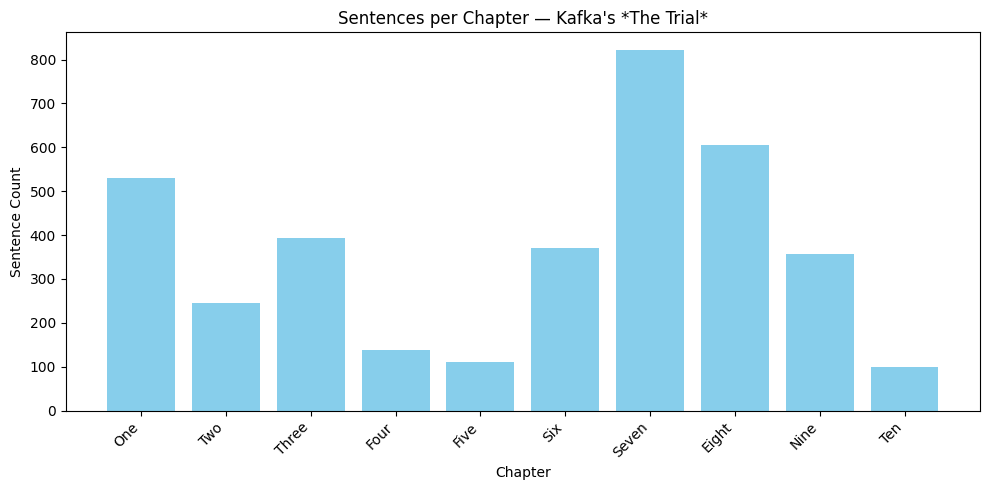

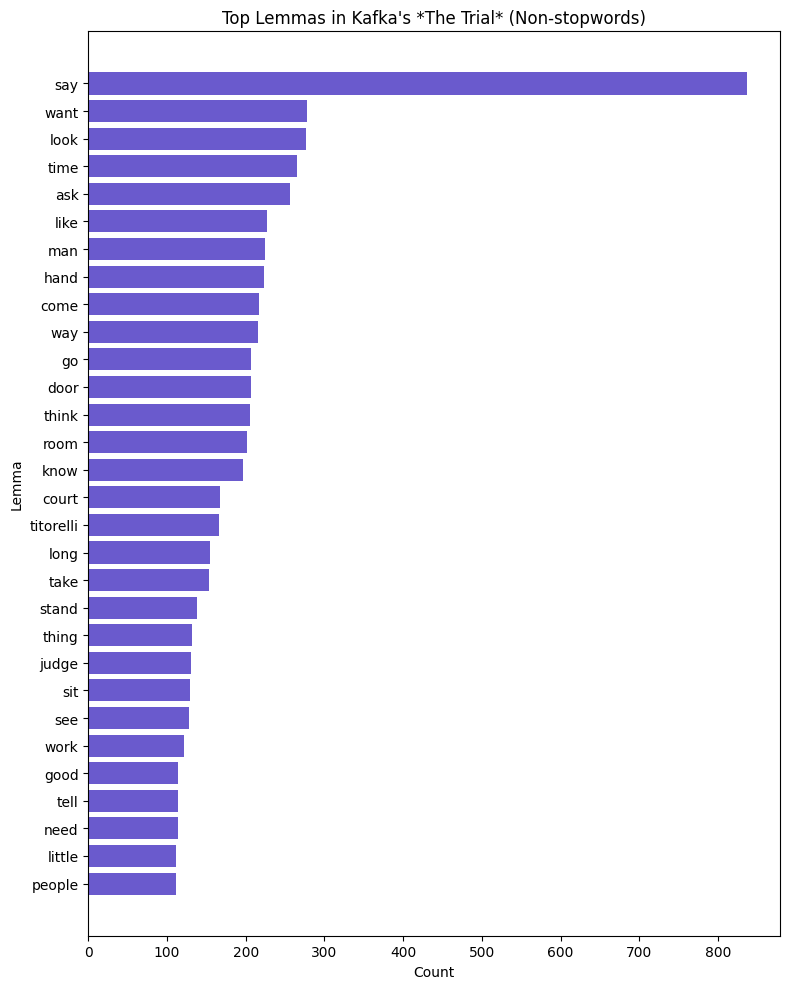

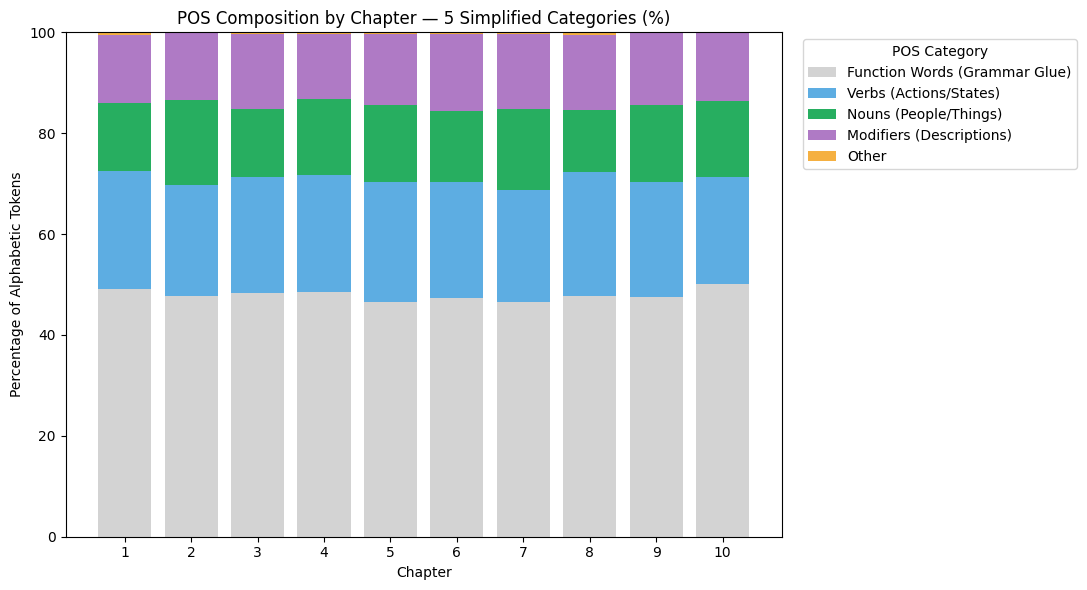

✅ Saved outputs to: /Users/shikha/Desktop/MTL RESEARCH/out
 - fig_sentences_per_chapter.png
 - fig_top_lemmas_overall.png
 - fig_pos_5categories_by_chapter.png
 - sentences_per_chapter.csv
 - top_lemmas_overall.csv
 - pos_5categories_by_chapter.csv


In [60]:
# PHASE 2.1 — Essential Visuals: Sentences, Top Lemmas, POS (5 categories)
# ------------------------------------------------------------------------
# Assumes you already have:
#   df_sents: columns [chapter, chapter_title, sent_id, text]
#   df_toks : columns [chapter, sent_id, token, lemma, pos, is_alpha, is_stop]
#
# Outputs to ./out:
#   - sentences_per_chapter.csv
#   - top_lemmas_overall.csv
#   - pos_5categories_by_chapter.csv
#   - fig_sentences_per_chapter.png
#   - fig_top_lemmas_overall.png
#   - fig_pos_5categories_by_chapter.png

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Output dir ---
OUT = Path("out"); OUT.mkdir(exist_ok=True)

# --- Basic guards (friendly errors if something’s missing) ---
need_sents = {"chapter", "chapter_title", "sent_id", "text"}
need_toks  = {"chapter", "sent_id", "lemma", "pos", "is_alpha", "is_stop"}
assert need_sents.issubset(df_sents.columns), f"df_sents must contain {need_sents}"
assert need_toks.issubset(df_toks.columns),   f"df_toks must contain {need_toks}"

# Normalize boolean dtypes (some parquet/csv loaders coerce to ints/strings)
df_toks = df_toks.copy()
df_toks["is_alpha"] = df_toks["is_alpha"].astype(bool)
df_toks["is_stop"]  = df_toks["is_stop"].astype(bool)

# ============================================================
# 1) Sentences per Chapter
# ============================================================
sent_per_ch = (
    df_sents.groupby(["chapter","chapter_title"])
            .size()
            .rename("sentence_count")
            .reset_index()
            .sort_values("chapter")
)

# nicer x labels: drop the literal "Chapter " prefix
sent_per_ch["label"] = sent_per_ch["chapter_title"].str.replace(
    r"(?i)^\s*chapter\s*", "", regex=True
)

sent_per_ch.to_csv(OUT/"sentences_per_chapter.csv", index=False)

plt.figure(figsize=(10,5))
plt.bar(sent_per_ch["label"], sent_per_ch["sentence_count"], color="skyblue")
plt.title("Sentences per Chapter — Kafka's *The Trial*")
plt.xlabel("Chapter")
plt.ylabel("Sentence Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(OUT/"fig_sentences_per_chapter.png", dpi=200)
plt.show()

# ============================================================
# 2) Top Lemmas Overall (non-stop, alphabetic only)
# ============================================================
df_toks["lemma_l"] = df_toks["lemma"].astype(str).str.lower()
tok_content = df_toks[(df_toks["is_alpha"]) & (~df_toks["is_stop"])]

top_lemmas = (
    tok_content["lemma_l"].value_counts().head(30)
              .rename_axis("lemma").reset_index(name="count")
)
top_lemmas.to_csv(OUT/"top_lemmas_overall.csv", index=False)

plt.figure(figsize=(8,10))
tl = top_lemmas.iloc[::-1]  # largest at top
plt.barh(tl["lemma"], tl["count"], color="slateblue")
plt.title("Top Lemmas in Kafka's *The Trial* (Non-stopwords)")
plt.xlabel("Count")
plt.ylabel("Lemma")
plt.tight_layout()
plt.savefig(OUT/"fig_top_lemmas_overall.png", dpi=200)
plt.show()

# ============================================================
# 3) POS Composition — 5 Simple Buckets
# ============================================================
# Buckets (with tiny examples):
#   1) Nouns (People/Things): NOUN, PROPN   → e.g., court, law, man
#   2) Verbs (Actions/States): VERB, AUX    → e.g., run, be, speak
#   3) Modifiers (Descriptions): ADJ, ADV   → e.g., dark, quietly
#   4) Function Words (Grammar Glue): PRON, DET, ADP, CCONJ, SCONJ, PART, NUM
#      → e.g., he, the, of, and, that, to, not, three
#   5) Other: everything else (INTJ, SYM, X, PUNCT if any stayed alpha=False)

tok_alpha = df_toks[df_toks["is_alpha"] == True].copy()

def pos_bucket(pos: str) -> str:
    if pos in ("NOUN", "PROPN"):
        return "Nouns (People/Things)"
    if pos in ("VERB", "AUX"):
        return "Verbs (Actions/States)"
    if pos in ("ADJ", "ADV"):
        return "Modifiers (Descriptions)"
    if pos in ("PRON", "DET", "ADP", "CCONJ", "SCONJ", "PART", "NUM"):
        return "Function Words (Grammar Glue)"
    return "Other"

tok_alpha["pos_bucket"] = tok_alpha["pos"].map(pos_bucket)

counts = (
    tok_alpha.groupby(["chapter", "pos_bucket"])
             .size()
             .rename("count")
             .reset_index()
)
totals = tok_alpha.groupby("chapter").size().rename("total").reset_index()
pct = counts.merge(totals, on="chapter")
pct["percent"] = (pct["count"] / pct["total"]) * 100

order = [
    "Function Words (Grammar Glue)",
    "Verbs (Actions/States)",
    "Nouns (People/Things)",
    "Modifiers (Descriptions)",
    "Other",
]
colors = {
    "Function Words (Grammar Glue)": "#D3D3D3",
    "Verbs (Actions/States)": "#5DADE2",
    "Nouns (People/Things)": "#27AE60",
    "Modifiers (Descriptions)": "#AF7AC5",
    "Other": "#F5B041",
}

pivot = (
    pct.pivot(index="chapter", columns="pos_bucket", values="percent")
       .reindex(columns=order)
       .fillna(0)
       .sort_index()
)
pivot.to_csv(OUT/"pos_5categories_by_chapter.csv")

plt.figure(figsize=(11,6))
bottom = np.zeros(len(pivot))
for col in order:
    vals = pivot[col].values
    plt.bar(pivot.index, vals, bottom=bottom, label=col, color=colors[col])
    bottom += vals

plt.title("POS Composition by Chapter — 5 Simplified Categories (%)")
plt.xlabel("Chapter"); plt.ylabel("Percentage of Alphabetic Tokens")
plt.xticks(pivot.index)
plt.legend(title="POS Category", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.savefig(OUT/"fig_pos_5categories_by_chapter.png", dpi=200)
plt.show()

print("✅ Saved outputs to:", OUT.resolve())
print(" - fig_sentences_per_chapter.png")
print(" - fig_top_lemmas_overall.png")
print(" - fig_pos_5categories_by_chapter.png")
print(" - sentences_per_chapter.csv")
print(" - top_lemmas_overall.csv")
print(" - pos_5categories_by_chapter.csv")


— Lemma alignment coverage —
Machinery: aligned=167  missing= 40  sample_missing=['actions', 'advocates', 'answers', 'applications', 'arrested', 'authorities']
Mirror   : aligned= 71  missing=  7  sample_missing=['dreaming', 'harassing', 'pretending', 'revolting', 'staggered', 'suffered']
Loop     : aligned= 37  missing=  0  sample_missing=[]
Beyond   : aligned= 22  missing=  5  sample_missing=['offered', 'offering', 'pronouncements', 'sins', 'superstitions']
Corridor : aligned= 59  missing=  9  sample_missing=['crouching', 'directions', 'fingers', 'hunched', 'inherited', 'sizes']

— POS guards configured —
Machinery: appeal, charge, court, free, law, record, trial
Loop     : again, maybe, nothing, perhaps
Beyond   : belief, confess, mercy
Corridor : dark, door, room, stairway, window


/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_1473/1994109582.py:277: UserWarning: Glyph 129694 (\N{MIRROR}) missing from current font.
  plt.tight_layout(); plt.savefig(OUT/"fig_modalities_line.png", dpi=200); plt.show()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_1473/1994109582.py:277: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from current font.
  plt.tight_layout(); plt.savefig(OUT/"fig_modalities_line.png", dpi=200); plt.show()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_1473/1994109582.py:277: UserWarning: Glyph 127756 (\N{MILKY WAY}) missing from current font.
  plt.tight_layout(); plt.savefig(OUT/"fig_modalities_line.png", dpi=200); plt.show()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_1473/1994109582.py:277: UserWarning: Glyph 128682 (\N{DOOR}) missing from current font.
  plt.tight_layout(); plt.savefig(OUT/"fig_modalities_line.png", dpi=200); plt.show()
/Library/Fra

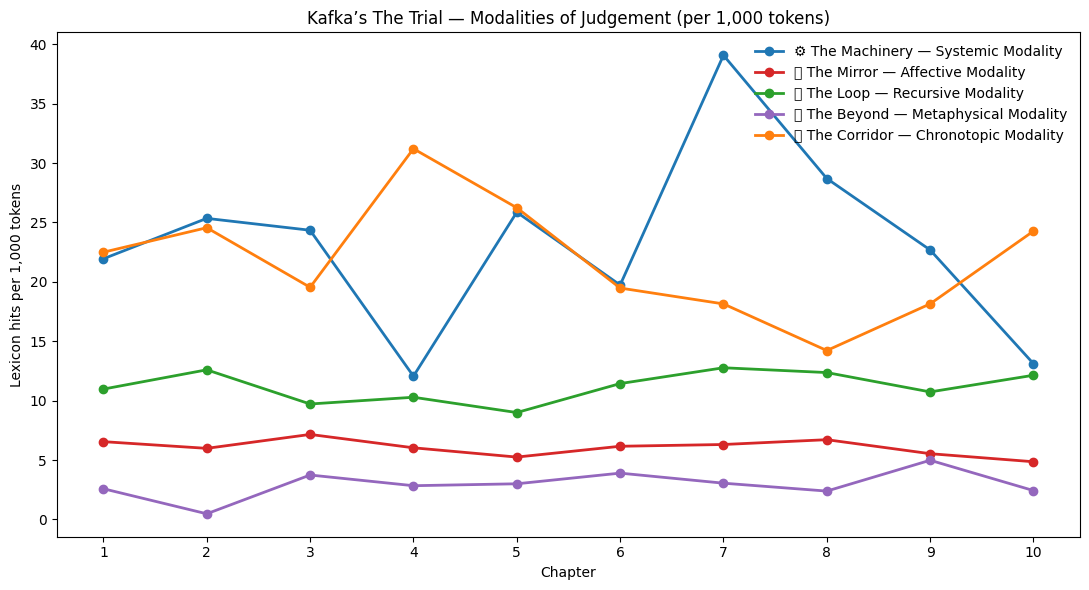

/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_1473/1994109582.py:290: UserWarning: Glyph 129694 (\N{MIRROR}) missing from current font.
  plt.tight_layout(); plt.savefig(OUT/"fig_modalities_stacked_area.png", dpi=200); plt.show()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_1473/1994109582.py:290: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from current font.
  plt.tight_layout(); plt.savefig(OUT/"fig_modalities_stacked_area.png", dpi=200); plt.show()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_1473/1994109582.py:290: UserWarning: Glyph 127756 (\N{MILKY WAY}) missing from current font.
  plt.tight_layout(); plt.savefig(OUT/"fig_modalities_stacked_area.png", dpi=200); plt.show()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_1473/1994109582.py:290: UserWarning: Glyph 128682 (\N{DOOR}) missing from current font.
  plt.tight_layout(); plt.savefig(OUT/"fig_modalities_stacked_area.png", d

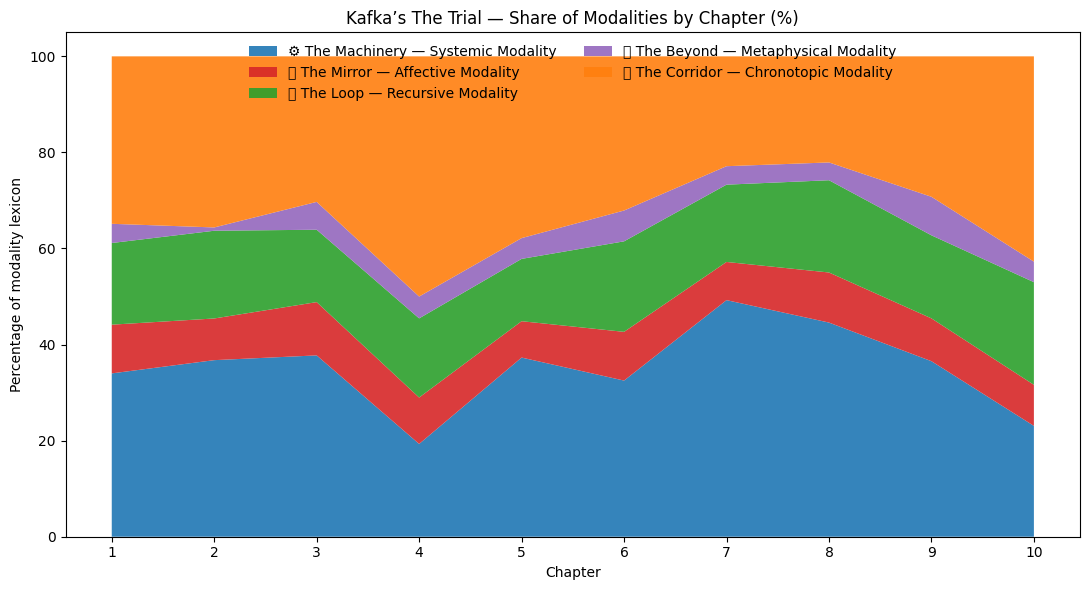

/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_1473/1994109582.py:299: UserWarning: Glyph 129694 (\N{MIRROR}) missing from current font.
  plt.tight_layout(); plt.savefig(OUT/"fig_modalities_heatmap.png", dpi=200); plt.show()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_1473/1994109582.py:299: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from current font.
  plt.tight_layout(); plt.savefig(OUT/"fig_modalities_heatmap.png", dpi=200); plt.show()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_1473/1994109582.py:299: UserWarning: Glyph 127756 (\N{MILKY WAY}) missing from current font.
  plt.tight_layout(); plt.savefig(OUT/"fig_modalities_heatmap.png", dpi=200); plt.show()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_1473/1994109582.py:299: UserWarning: Glyph 128682 (\N{DOOR}) missing from current font.
  plt.tight_layout(); plt.savefig(OUT/"fig_modalities_heatmap.png", dpi=200); plt.show()


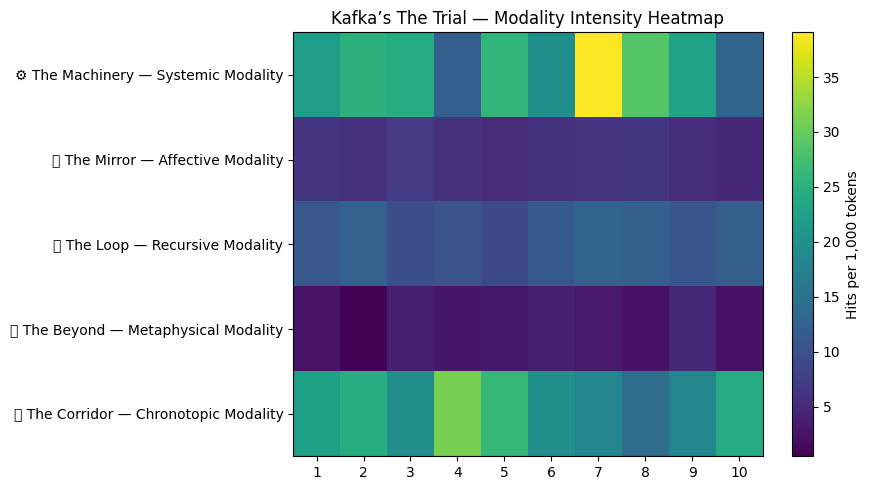

In [11]:
# KAFKA — Lemma-aligned Lexicon Profiling (Corrected & POS-aware)
# ---------------------------------------------------------------
# Requirements:
#   pip install pandas pyarrow matplotlib
# Inputs:
#   data/tokens.parquet  -> columns: chapter, lemma, pos, is_alpha
#   data/sentences.csv   -> (only if INCLUDE_PHRASES=True) columns: chapter, sent_id, text
# Outputs:
#   out/lexicon_by_chapter__per1k__modalities.csv
#   out/fig_modalities_line.png
#   out/fig_modalities_stacked_area.png
#   out/fig_modalities_heatmap.png

from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------
# 0) Load corpus tables
# ---------------------------------
BASE = Path("data")
OUT = Path("out"); OUT.mkdir(exist_ok=True)

TOKENS = pd.read_parquet(BASE / "tokens.parquet").copy()
TOKENS["lemma_l"] = TOKENS["lemma"].astype(str).str.lower()
TOKENS = TOKENS[TOKENS["is_alpha"] == True]
chapters = sorted(TOKENS["chapter"].unique())

# Toggle phrase counting (multi-word items)
INCLUDE_PHRASES = False
if INCLUDE_PHRASES:
    sents = pd.read_csv(BASE / "sentences.csv").copy()
    def norm_quotes(s: str) -> str:
        return (s.replace("’","'").replace("‘","'")
                 .replace("“",'"').replace("”",'"'))
    sents["text_l"] = sents["text"].astype(str).map(norm_quotes).str.lower()

# ---------------------------------
# 1) Your five modality lists (raw)
#    (kept as you provided; we will fix issues below)
# ---------------------------------
Systemic = ['eyes', 'gaze','innocent','law','innocence','trial','laws',
    'arrested','proceeding','litigant','cases','position','order','authorities','high officials','police',
    'officers','free','policemen','high position','witness','inspection','indicted','offence','situation',
    'charge','advise','behave','behaviour','favour','attorney','independent','dependent','serious','crime',
    'simple','complicated','agreement','value','punish','persuade','secrets','forced','forbid','investigating',
    'prison','legal','responsible','obligation','imposed','acknowledgement','judiciary','bribe','corrupt',
    'pretence','organisation','hearings','session','summon','misjudged','judgement','verdict','reports',
    'documents','book','court','entrap','detained','jurisprudence','evidence','applications','suffering','delay',
    'complained','punishment','career','job','inhumane','degeneracy','sacrifice','control','blame','guilty',
    'defence','barrister','agree','agreement','compliance','vain','names','questions','answers','records','written',
    'warrant','observing','questioning','tolerated','dispute','strictly','conditions','situations','dignity',
    'respect','hidden','secret','advocates','influence','progress','favourable','crowd','public','private',
    'confusion','difficulties','injustice','allocated','civil servants','flattering','mood','acumen','revenge',
    'attractive','attract','stage','process','actions','difficult','concealed','danger','choice','important',
    'reject','accept','rights','contract','trustee','governing','rules','contact','acquittal','inconsistency',
    'cite','possibilities','re-arrest','reasons','interrogations','injunctions','obeyed','investigations','commands',
    'convicted','achieve','result','charge','subjugate','gaze','warning','reprimanding','harassing','trap','free',
    'hold','release','deluded','deceit','service','organism','objections','lose', 'negotiation', 'negotiating', 'restricting','name','identity','joke', 'discipline', 'circumstances'
]

Affective = [
    'embarrassed','danger','alone','startled','confused','surprised','attentive','distracted','satisfied','alert',
    'aware','sensibly','disorder','helpless','tiredness','humiliated','repulsive','inattentive','pressure','pity',
    'revolting','humiliation','dizzy','unpleasant','irritation','impression','setback','suffered',
    'imagining','dreaming','weak','tears','tired','disgrace','bold','immobile','silent','despair','passive',
    'dragged','ambush','confidence','dulled','unbearable','anticipation','exertion','stress','worry',
    'unhealthy','staggered','resentment','pretending','anxiety','fear','temper','harassing','burden',
    'depress','disgust','immediately','threat','mistake','courage','damage','helpless','indifferent','harm',
    'attractive','pretence','pretend','suddenly','laugh','vague','tears'
]

# NOTE: had missing comma after 'circle' and typos; fixed below
Recursive = ['circle',
    'again','nothing','someone','somebody','maybe','probably','perhaps','suppose','first','last','final',
    'similar','different','contradict','necessary','unnecessary','understood','misunderstand','misunderstood',
    'comprehensible','incomprehensible','endless','nonsense','incalculable','bigger','smaller','incomparably',
    'everything','pointless','don’t know','great','beyond','important','unimportant','irrefutable','absolute',
    'relative','no sense','any sense'
]

Theological = [
    'confess','forbid','pronouncements','superstitions','superstitious','christian','offered','offering','mercy',
    'believe','belief','forbidden','sins','counsel','God','beyond','forgiveness','human','humane','weakness',
    'strength','help', 'cathedral'
]

# Chronotopic had concatenation & typos; we replace with a corrected set
Chronotopic = [
    'window','door','open window','close window','stairway','air','dark','darkness','grey','candle','torch','loud',
    'shout','room','stairwell','building','walls','ceiling','bell','murderous tone','bigger than him','bent head',
    'bowed head','sizes','fingers','animal','crouching','attic','narrow','passage','steps','inherited','hunchbacked',
    'hunched','creep','organism','degeneracy','day','night','chair','directions','street','entrance','passageway',
    'yard','floor','evening','morning','light','disappear','space','corridor','time','smoke','sun','moon','fog',
    'soot','dull','dim','doorway','hallway','stairs','voice','direction', 'offices','fog','attic',
]

# ---------------------------------
# 2) Clean, normalize, deduplicate
# ---------------------------------
def _clean_list(lst):
    seen, out = set(), []
    for w in lst:
        w2 = re.sub(r"\s+", " ", str(w)).strip()
        if w2 and w2 not in seen:
            seen.add(w2); out.append(w2)
    return out

Systemic    = _clean_list(Systemic)
Affective   = _clean_list(Affective)
Recursive   = _clean_list(Recursive)
Theological = _clean_list(Theological)
Chronotopic = _clean_list(Chronotopic)

# Rebuild mapping after cleaning
LEX = {
    "Machinery": Systemic,    # ⚙️ The Machinery — Systemic
    "Mirror":    Affective,   # 🪞 The Mirror — Affective
    "Loop":      Recursive,   # 🔁 The Loop — Recursive/Contradictory
    "Beyond":    Theological, # 🌌 The Beyond — Metaphysical
    "Corridor":  Chronotopic, # 🚪 The Corridor — Chronotopic/Architectural
}

PRETTY = {
    "Machinery": "⚙️ The Machinery — Systemic Modality",
    "Mirror":    "🪞 The Mirror — Affective Modality",
    "Loop":      "🔁 The Loop — Recursive Modality",
    "Beyond":    "🌌 The Beyond — Metaphysical Modality",
    "Corridor":  "🚪 The Corridor — Chronotopic Modality",
}

COLORS = {
    "Machinery": "#1f77b4",
    "Mirror":    "#d62728",
    "Loop":      "#2ca02c",
    "Beyond":    "#9467bd",
    "Corridor":  "#ff7f0e",
}

# ---------------------------------
# 3) Lemma-align unigrams (exactly to corpus lemmas) + keep phrases separate
# ---------------------------------
lemma_vocab = set(TOKENS["lemma_l"].astype(str))

def _norm_item(x: str) -> str:
    return re.sub(r"\s+", " ", str(x).strip().lower())

def _is_phrase(x: str) -> bool:
    return bool(re.search(r"\s", str(x).strip()))

def _cheap_lemma_guess(w: str) -> str:
    w = _norm_item(w)
    if w in lemma_vocab:
        return w
    # simple conservative stemming guesses
    for pat, rep in (("ies$", "y"), ("sses$", "ss"), ("es$", ""), ("s$", ""),
                     ("ing$", ""), ("ed$", "")):
        cand = re.sub(pat, rep, w)
        if cand in lemma_vocab:
            return cand
    return w

UNIGRAMS_RAW = {mod: [_norm_item(w) for w in words if not _is_phrase(w)]
                for mod, words in LEX.items()}
PHRASES_RAW  = {mod: [_norm_item(w) for w in words if _is_phrase(w)]
                for mod, words in LEX.items()}

LEX_UNIG_LEMMA = {
    mod: sorted({_cheap_lemma_guess(w) for w in words if w})
    for mod, words in UNIGRAMS_RAW.items()
}

# ---------------------------------
# 4) POS guards (optional disambiguation)
# ---------------------------------
LEX_POS = {
    "Machinery": {
        "court": {"NOUN", "PROPN"},
        "charge": {"NOUN"},
        "free": {"ADJ"},
        "law": {"NOUN"},
        "trial": {"NOUN"},
        "record": {"NOUN"} if "record" in lemma_vocab else set(),
        "appeal": {"NOUN"} if "appeal" in lemma_vocab else set(),
    },
    "Mirror": {
        # add if you see noise
    },
    "Loop": {
        "again": {"ADV"} if "again" in lemma_vocab else set(),
        "nothing": {"PRON","NOUN"} if "nothing" in lemma_vocab else set(),
        "perhaps": {"ADV"} if "perhaps" in lemma_vocab else set(),
        "maybe": {"ADV"} if "maybe" in lemma_vocab else set(),
    },
    "Beyond": {
        "confess": {"VERB"} if "confess" in lemma_vocab else set(),
        "belief": {"NOUN"} if "belief" in lemma_vocab else set(),
        "mercy": {"NOUN"} if "mercy" in lemma_vocab else set(),
    },
    "Corridor": {
        "window": {"NOUN"} if "window" in lemma_vocab else set(),
        "door": {"NOUN"} if "door" in lemma_vocab else set(),
        "dark": {"ADJ","NOUN"} if "dark" in lemma_vocab else set(),
        "room": {"NOUN"} if "room" in lemma_vocab else set(),
        "stairway": {"NOUN"} if "stairway" in lemma_vocab else set(),
    },
}

# ---------------------------------
# 5) Counting (lemma-aligned + optional phrases) — POS-aware
# ---------------------------------
def count_unigrams_pos_aware(modality: str) -> pd.Series:
    lemmas = set(LEX_UNIG_LEMMA.get(modality, []))
    if not lemmas:
        return pd.Series(0, index=chapters)
    sub = TOKENS[TOKENS["lemma_l"].isin(lemmas)]
    guards = LEX_POS.get(modality, {})
    if guards:
        sub = sub[(~sub["lemma_l"].isin(guards.keys())) |
                  (sub.apply(lambda r: r["pos"] in guards.get(r["lemma_l"], set()), axis=1))]
    return sub.groupby("chapter").size().reindex(chapters, fill_value=0)

def count_phrases_literal(modality: str) -> pd.Series:
    if not INCLUDE_PHRASES:
        return pd.Series(0, index=chapters)
    phrases = PHRASES_RAW.get(modality, [])
    if not phrases:
        return pd.Series(0, index=chapters)
    totals = pd.Series(0, index=chapters, dtype="int64")
    for ph in phrases:
        pat = re.compile(re.escape(ph))
        per_ch = (sents.groupby("chapter")["text_l"]
                  .apply(lambda col: col.apply(lambda x: len(pat.findall(x))).sum()))
        totals = totals.add(per_ch, fill_value=0)
    return totals.reindex(chapters, fill_value=0)

raw_counts = {}
for MOD in LEX.keys():
    u = count_unigrams_pos_aware(MOD)
    p = count_phrases_literal(MOD)
    raw_counts[MOD] = (u + p).astype(int)

counts_df = pd.DataFrame(raw_counts).reindex(chapters).fillna(0).astype(int)
tokens_per_ch = TOKENS.groupby("chapter").size().reindex(chapters)
per1k = (counts_df.div(tokens_per_ch, axis=0) * 1000).fillna(0)

(per1k.round(3)).to_csv(OUT / "lexicon_by_chapter__per1k__modalities.csv")

# ---------------------------------
# 6) Sanity checks
# ---------------------------------
print("\n— Lemma alignment coverage —")
for mod, words in LEX.items():
    orig = {w.lower() for w in words if " " not in w}
    aligned = set(LEX_UNIG_LEMMA.get(mod, []))
    missing = sorted(orig - aligned)
    print(f"{mod:9s}: aligned={len(aligned):3d}  missing={len(missing):3d}  sample_missing={missing[:6]}")

print("\n— POS guards configured —")
for mod, guards in LEX_POS.items():
    if guards:
        print(f"{mod:9s}: {', '.join(sorted([k for k,v in guards.items() if v]))}")

# ---------------------------------
# 7) Visuals (line, stacked area, heatmap)
# ---------------------------------
plt.figure(figsize=(11,6))
for key in LEX:
    plt.plot(per1k.index, per1k[key], marker="o", linewidth=2.0,
             label=PRETTY[key], color=COLORS[key])
plt.title("Kafka’s The Trial — Modalities of Judgement (per 1,000 tokens)")
plt.xlabel("Chapter"); plt.ylabel("Lexicon hits per 1,000 tokens")
plt.xticks(per1k.index)
plt.legend(loc="upper right", frameon=False)
plt.tight_layout(); plt.savefig(OUT/"fig_modalities_line.png", dpi=200); plt.show()

share = per1k.div(per1k.sum(axis=1).replace(0, np.nan), axis=0).fillna(0) * 100.0
plt.figure(figsize=(11,6))
xs = np.arange(len(share.index))
ys = [share[k].values for k in LEX]
labels = [PRETTY[k] for k in LEX]
colors = [COLORS[k] for k in LEX]
plt.stackplot(xs, ys, labels=labels, colors=colors, alpha=0.9)
plt.title("Kafka’s The Trial — Share of Modalities by Chapter (%)")
plt.xlabel("Chapter"); plt.ylabel("Percentage of modality lexicon")
plt.xticks(xs, share.index)
plt.legend(loc="upper center", ncol=2, frameon=False)
plt.tight_layout(); plt.savefig(OUT/"fig_modalities_stacked_area.png", dpi=200); plt.show()

plt.figure(figsize=(9,5))
mat = per1k[[k for k in LEX]].T.values  # rows = modalities, cols = chapters
plt.imshow(mat, aspect="auto", cmap="viridis")
plt.colorbar(label="Hits per 1,000 tokens")
plt.yticks(ticks=np.arange(len(LEX)), labels=[PRETTY[k] for k in LEX])
plt.xticks(ticks=np.arange(len(per1k.index)), labels=per1k.index)
plt.title("Kafka’s The Trial — Modality Intensity Heatmap")
plt.tight_layout(); plt.savefig(OUT/"fig_modalities_heatmap.png", dpi=200); plt.show()

In [12]:
# Recreate modality keys from per1k if needed
modalities = list(per1k.columns)

# Core modality list (should match how you built per1k)
# If your columns are exactly ["Machinery","Mirror","Loop","Beyond","Corridor"],
# this is in sync.
LEX = {m: None for m in modalities}  # dummy values; we only use keys for plotting

# Pretty labels for legend
PRETTY = {
    "Machinery": "⚙️ The Machinery — Systemic Modality",
    "Mirror":    "🪞 The Mirror — Affective Modality",
    "Loop":      "🔁 The Loop — Recursive Modality",
    "Beyond":    "🌌 The Beyond — Metaphysical Modality",
    "Corridor":  "🚪 The Corridor — Chronotopic Modality",
}

# Colors for each modality (same as your earlier scheme)
COLORS = {
    "Machinery": "#1f77b4",
    "Mirror":    "#d62728",
    "Loop":      "#2ca02c",
    "Beyond":    "#9467bd",
    "Corridor":  "#ff7f0e",
}

/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_1473/2991910631.py:33: UserWarning: Glyph 129694 (\N{MIRROR}) missing from current font.
  plt.tight_layout(rect=[0, 0, 0.8, 1])
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_1473/2991910631.py:33: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from current font.
  plt.tight_layout(rect=[0, 0, 0.8, 1])
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_1473/2991910631.py:33: UserWarning: Glyph 127756 (\N{MILKY WAY}) missing from current font.
  plt.tight_layout(rect=[0, 0, 0.8, 1])
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_1473/2991910631.py:33: UserWarning: Glyph 128682 (\N{DOOR}) missing from current font.
  plt.tight_layout(rect=[0, 0, 0.8, 1])
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_1473/2991910631.py:35: UserWarning: Glyph 129694 (\N{MIRROR}) missing from current font.
  plt.savefig(OUT / "fig_modalities_line.png", dpi=2

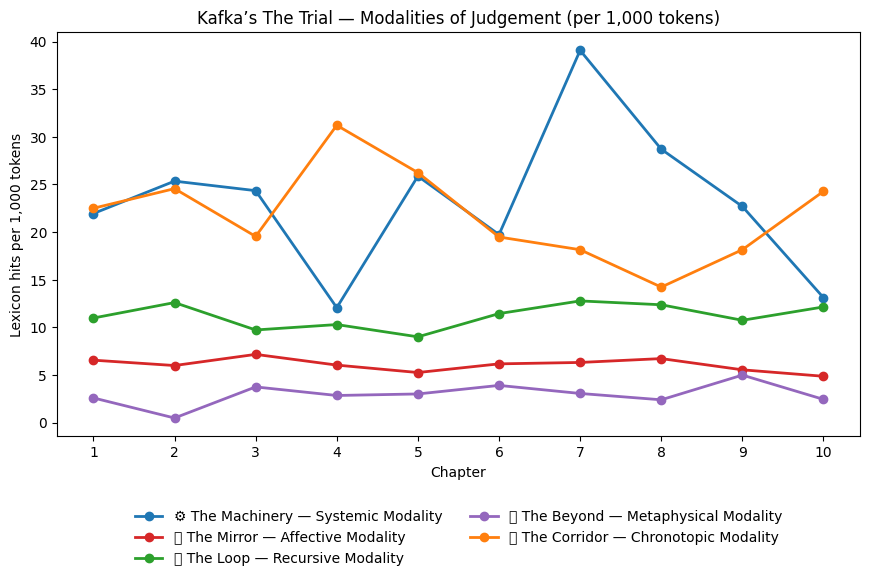

/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_1473/2991910631.py:64: UserWarning: Glyph 129694 (\N{MIRROR}) missing from current font.
  plt.tight_layout()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_1473/2991910631.py:64: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from current font.
  plt.tight_layout()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_1473/2991910631.py:64: UserWarning: Glyph 127756 (\N{MILKY WAY}) missing from current font.
  plt.tight_layout()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_1473/2991910631.py:64: UserWarning: Glyph 128682 (\N{DOOR}) missing from current font.
  plt.tight_layout()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_1473/2991910631.py:65: UserWarning: Glyph 129694 (\N{MIRROR}) missing from current font.
  plt.savefig(OUT / "fig_modalities_stacked_area.png", dpi=200)
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_1473/

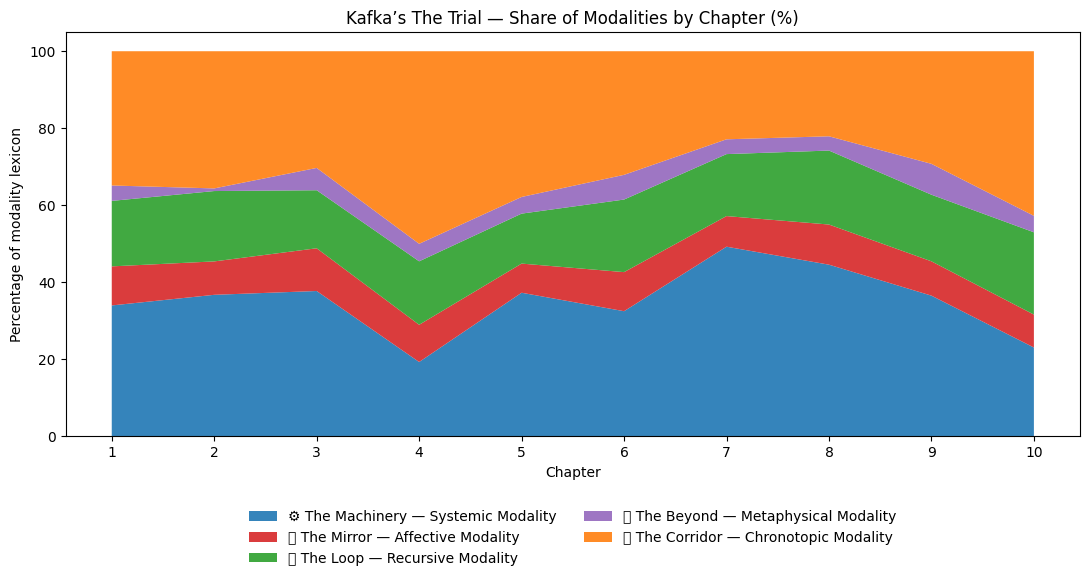

/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_1473/2991910631.py:86: UserWarning: Glyph 129694 (\N{MIRROR}) missing from current font.
  plt.tight_layout()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_1473/2991910631.py:86: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from current font.
  plt.tight_layout()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_1473/2991910631.py:86: UserWarning: Glyph 127756 (\N{MILKY WAY}) missing from current font.
  plt.tight_layout()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_1473/2991910631.py:86: UserWarning: Glyph 128682 (\N{DOOR}) missing from current font.
  plt.tight_layout()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_1473/2991910631.py:87: UserWarning: Glyph 129694 (\N{MIRROR}) missing from current font.
  plt.savefig(OUT / "fig_modalities_heatmap.png", dpi=200)
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_1473/29919

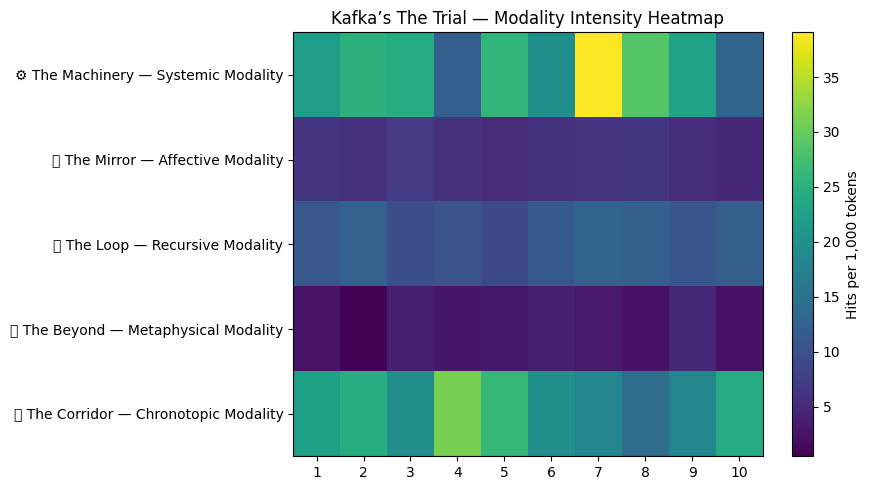

In [14]:
# ---------------------------------
# 7) Visuals (line, stacked area, heatmap)
# ---------------------------------

# --- 7.1 Modalities line plot (legend outside, right) ---
plt.figure(figsize=(11, 6))

for key in LEX:
    plt.plot(
        per1k.index,
        per1k[key],
        marker="o",
        linewidth=2.0,
        label=PRETTY[key],
        color=COLORS[key],
    )

plt.title("Kafka’s The Trial — Modalities of Judgement (per 1,000 tokens)")
plt.xlabel("Chapter")
plt.ylabel("Lexicon hits per 1,000 tokens")
plt.xticks(per1k.index)



plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=2,
    frameon=False,
)

# leave room on right for legend
plt.tight_layout(rect=[0, 0, 0.8, 1])

plt.savefig(OUT / "fig_modalities_line.png", dpi=200)
plt.show()


# --- 7.2 Modalities stacked area (legend below) ---
share = per1k.div(per1k.sum(axis=1).replace(0, np.nan), axis=0).fillna(0) * 100.0

plt.figure(figsize=(11, 6))

xs = np.arange(len(share.index))
ys = [share[k].values for k in LEX]
labels = [PRETTY[k] for k in LEX]
colors = [COLORS[k] for k in LEX]

plt.stackplot(xs, ys, labels=labels, colors=colors, alpha=0.9)

plt.title("Kafka’s The Trial — Share of Modalities by Chapter (%)")
plt.xlabel("Chapter")
plt.ylabel("Percentage of modality lexicon")
plt.xticks(xs, share.index)

# 👇 move legend below the plot, centered
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=2,
    frameon=False,
)

plt.tight_layout()
plt.savefig(OUT / "fig_modalities_stacked_area.png", dpi=200)
plt.show()


# --- 7.3 Modality heatmap (unchanged, legend is colorbar) ---
plt.figure(figsize=(9, 5))

mat = per1k[[k for k in LEX]].T.values  # rows = modalities, cols = chapters

plt.imshow(mat, aspect="auto", cmap="viridis")
plt.colorbar(label="Hits per 1,000 tokens")
plt.yticks(
    ticks=np.arange(len(LEX)),
    labels=[PRETTY[k] for k in LEX]
)
plt.xticks(
    ticks=np.arange(len(per1k.index)),
    labels=per1k.index
)
plt.title("Kafka’s The Trial — Modality Intensity Heatmap")

plt.tight_layout()
plt.savefig(OUT / "fig_modalities_heatmap.png", dpi=200)
plt.show()

/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_1473/289593979.py:34: UserWarning: Glyph 129694 (\N{MIRROR}) missing from current font.
  plt.tight_layout()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_1473/289593979.py:34: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from current font.
  plt.tight_layout()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_1473/289593979.py:34: UserWarning: Glyph 127756 (\N{MILKY WAY}) missing from current font.
  plt.tight_layout()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_1473/289593979.py:34: UserWarning: Glyph 128682 (\N{DOOR}) missing from current font.
  plt.tight_layout()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_1473/289593979.py:35: UserWarning: Glyph 129694 (\N{MIRROR}) missing from current font.
  plt.savefig(OUT / "fig_modalities_stacked_bar.png", dpi=200)
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_1473/289593

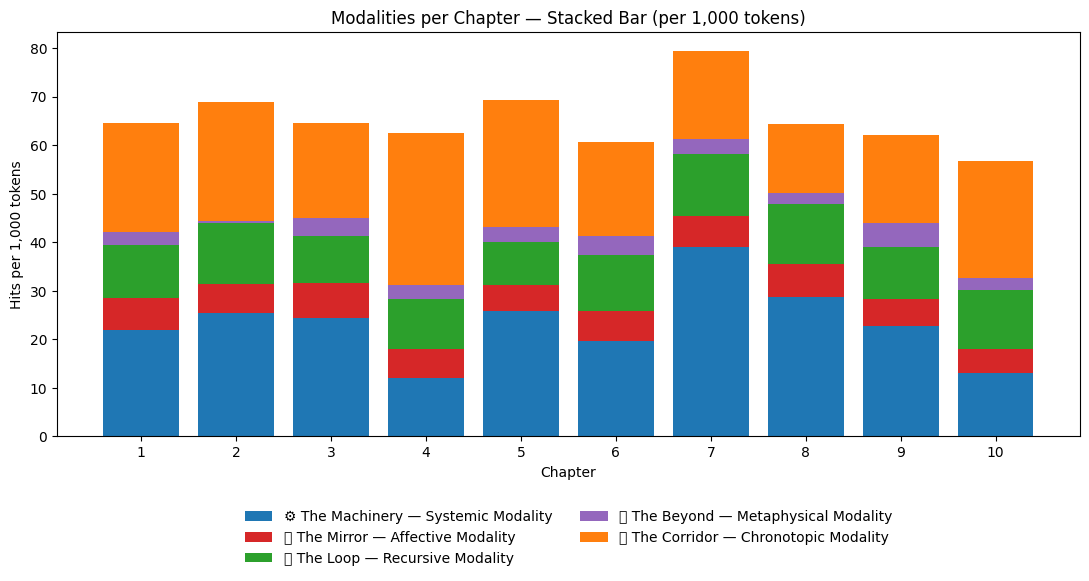

In [15]:
# VISUAL 4 — Stacked BAR: chapter-wise composition (per 1k)
import numpy as np

order = list(LEX.keys())
vals = per1k[order].values
x = np.arange(len(per1k.index))

plt.figure(figsize=(11, 6))
bottom = np.zeros(len(x))

for k in order:
    plt.bar(
        x,
        per1k[k].values,
        bottom=bottom,
        label=PRETTY[k],
        color=COLORS[k],
    )
    bottom += per1k[k].values

plt.title("Modalities per Chapter — Stacked Bar (per 1,000 tokens)")
plt.xlabel("Chapter")
plt.ylabel("Hits per 1,000 tokens")
plt.xticks(x, per1k.index)

# 👇 legend centered *below* the plot, same style as line graph
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=2,
    frameon=False,
)

plt.tight_layout()
plt.savefig(OUT / "fig_modalities_stacked_bar.png", dpi=200)
plt.show()

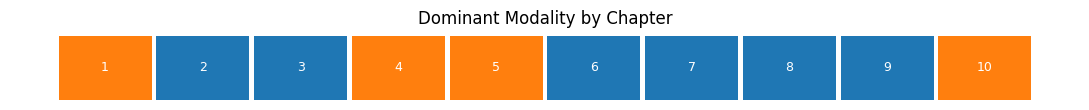

In [63]:
# VISUAL 5 — Dominance strip: top modality per chapter
top_key = per1k.idxmax(axis=1)  # modality name per chapter
colors = [COLORS[k] for k in top_key]

plt.figure(figsize=(11,1.2))
plt.bar(range(len(top_key)), [1]*len(top_key), color=colors, width=0.95)
for i, ch in enumerate(per1k.index):
    plt.text(i, 0.5, str(ch), ha="center", va="center", fontsize=9, color="white")
plt.yticks([]); plt.xticks([]); plt.box(False)
plt.title("Dominant Modality by Chapter")
plt.tight_layout(); plt.savefig(OUT/"fig_modalities_dominance_strip.png", dpi=200); plt.show()

/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_4776/3896082974.py:15: UserWarning: Glyph 129694 (\N{MIRROR}) missing from current font.
  plt.tight_layout(); plt.savefig(OUT/"fig_modalities_radar_avg.png", dpi=200); plt.show()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_4776/3896082974.py:15: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from current font.
  plt.tight_layout(); plt.savefig(OUT/"fig_modalities_radar_avg.png", dpi=200); plt.show()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_4776/3896082974.py:15: UserWarning: Glyph 127756 (\N{MILKY WAY}) missing from current font.
  plt.tight_layout(); plt.savefig(OUT/"fig_modalities_radar_avg.png", dpi=200); plt.show()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_4776/3896082974.py:15: UserWarning: Glyph 128682 (\N{DOOR}) missing from current font.
  plt.tight_layout(); plt.savefig(OUT/"fig_modalities_radar_avg.png", dpi=200); plt.sho

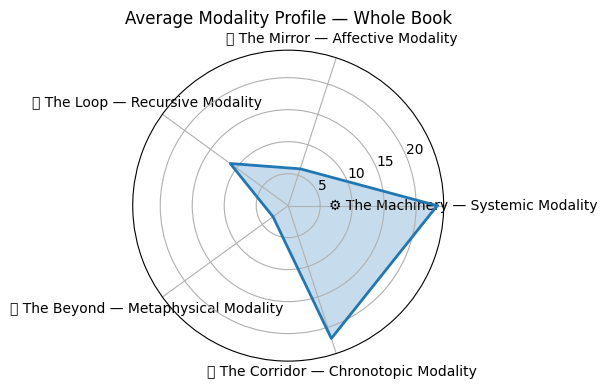

In [64]:
# VISUAL 10 — Radar (spider) for whole-book averages
import numpy as np
avg = per1k.mean(axis=0)[list(LEX.keys())].values
labels = list(LEX.keys())
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
avg = np.concatenate([avg, avg[:1]])
angles = np.concatenate([angles, angles[:1]])

plt.figure(figsize=(6,6))
ax = plt.subplot(111, polar=True)
ax.plot(angles, avg, linewidth=2)
ax.fill(angles, avg, alpha=0.25)
ax.set_thetagrids(angles[:-1] * 180/np.pi, [PRETTY[k] for k in LEX])
ax.set_title("Average Modality Profile — Whole Book")
plt.tight_layout(); plt.savefig(OUT/"fig_modalities_radar_avg.png", dpi=200); plt.show()

# (Optional) Small-multiples per chapter: set SMALL_MULTIPLES=False to skip
SMALL_MULTIPLES = False
if SMALL_MULTIPLES:
    n = len(per1k.index); cols = 5; rows = int(np.ceil(n/cols))
    fig = plt.figure(figsize=(3*cols, 3*rows))
    for i, ch in enumerate(per1k.index, 1):
        vals = per1k.loc[ch, list(LEX.keys())].values
        vals = np.concatenate([vals, vals[:1]])
        ax = plt.subplot(rows, cols, i, polar=True)
        ax.plot(angles, vals, linewidth=1)
        ax.fill(angles, vals, alpha=0.20)
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(f"Ch {ch}", fontsize=9)
    fig.suptitle("Modality Radar — per Chapter", y=0.98)
    plt.tight_layout(); plt.savefig(OUT/"fig_modalities_radar_small_multiples.png", dpi=200); plt.show()

/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_4776/619754816.py:9: UserWarning: Glyph 129694 (\N{MIRROR}) missing from current font.
  plt.tight_layout(); plt.savefig(OUT/"fig_modalities_cumulative.png", dpi=200); plt.show()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_4776/619754816.py:9: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from current font.
  plt.tight_layout(); plt.savefig(OUT/"fig_modalities_cumulative.png", dpi=200); plt.show()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_4776/619754816.py:9: UserWarning: Glyph 127756 (\N{MILKY WAY}) missing from current font.
  plt.tight_layout(); plt.savefig(OUT/"fig_modalities_cumulative.png", dpi=200); plt.show()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_4776/619754816.py:9: UserWarning: Glyph 128682 (\N{DOOR}) missing from current font.
  plt.tight_layout(); plt.savefig(OUT/"fig_modalities_cumulative.png", dpi=200); plt.show()


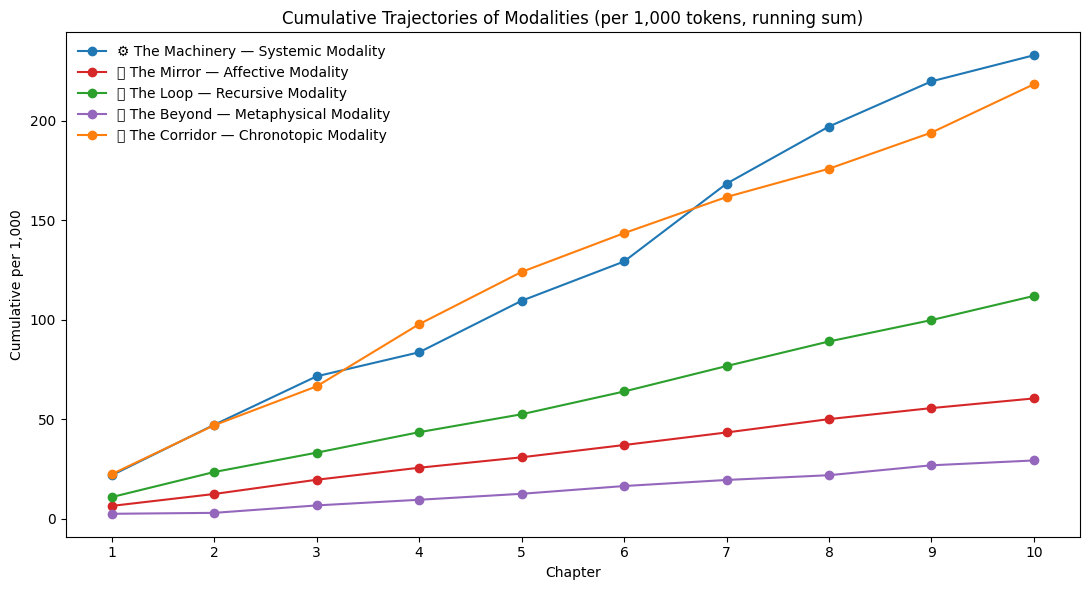

In [65]:
# VISUAL 11 — Cumulative trajectories (running sum of per1k)
cum = per1k.cumsum()
plt.figure(figsize=(11,6))
for k in LEX:
    plt.plot(cum.index, cum[k], marker="o", label=PRETTY[k], color=COLORS[k])
plt.title("Cumulative Trajectories of Modalities (per 1,000 tokens, running sum)")
plt.xlabel("Chapter"); plt.ylabel("Cumulative per 1,000")
plt.xticks(cum.index); plt.legend(frameon=False)
plt.tight_layout(); plt.savefig(OUT/"fig_modalities_cumulative.png", dpi=200); plt.show()

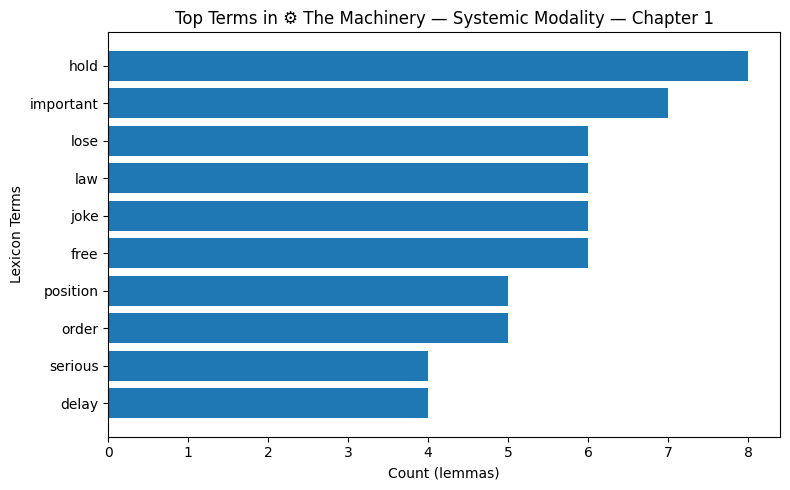

/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_4776/1733496390.py:30: UserWarning: Glyph 129694 (\N{MIRROR}) missing from current font.
  plt.tight_layout()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_4776/1733496390.py:31: UserWarning: Glyph 129694 (\N{MIRROR}) missing from current font.
  plt.savefig(OUT / f"fig_terms_top_{MOD}_ch{CH}.png", dpi=200)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129694 (\N{MIRROR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


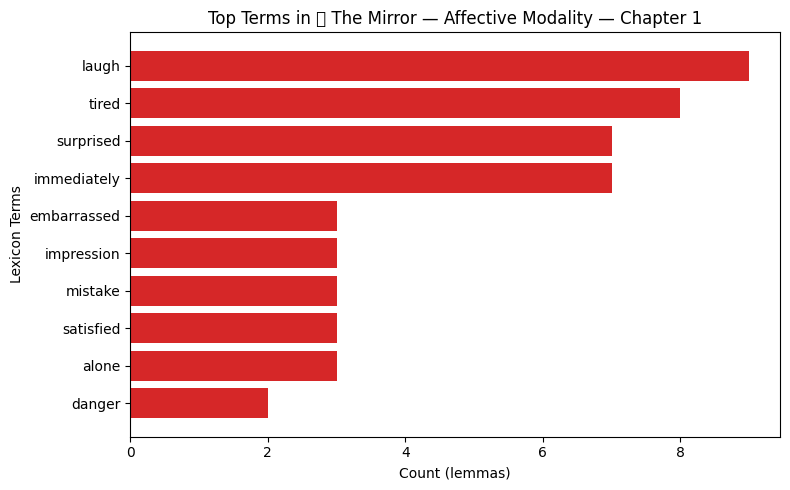

/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_4776/1733496390.py:30: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from current font.
  plt.tight_layout()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_4776/1733496390.py:31: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from current font.
  plt.savefig(OUT / f"fig_terms_top_{MOD}_ch{CH}.png", dpi=200)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


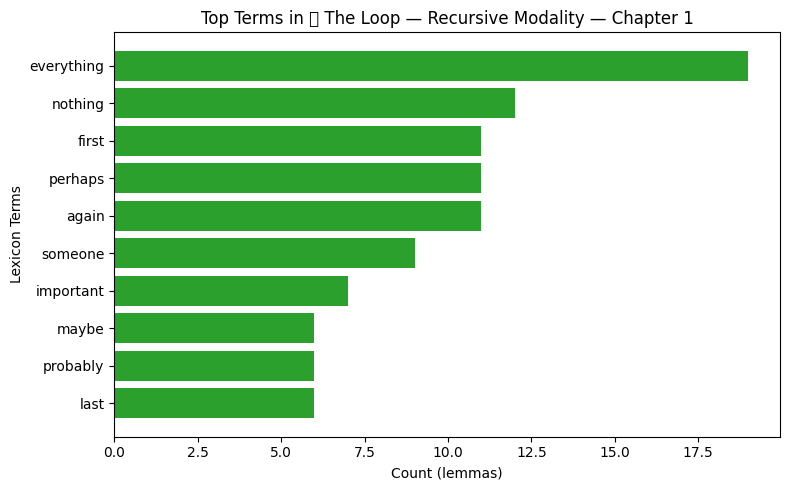

/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_4776/1733496390.py:30: UserWarning: Glyph 127756 (\N{MILKY WAY}) missing from current font.
  plt.tight_layout()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_4776/1733496390.py:31: UserWarning: Glyph 127756 (\N{MILKY WAY}) missing from current font.
  plt.savefig(OUT / f"fig_terms_top_{MOD}_ch{CH}.png", dpi=200)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127756 (\N{MILKY WAY}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


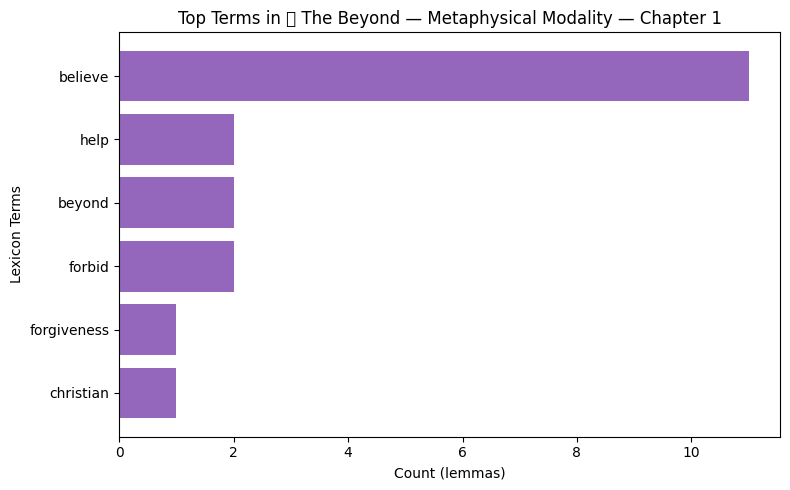

/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_4776/1733496390.py:30: UserWarning: Glyph 128682 (\N{DOOR}) missing from current font.
  plt.tight_layout()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_4776/1733496390.py:31: UserWarning: Glyph 128682 (\N{DOOR}) missing from current font.
  plt.savefig(OUT / f"fig_terms_top_{MOD}_ch{CH}.png", dpi=200)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128682 (\N{DOOR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


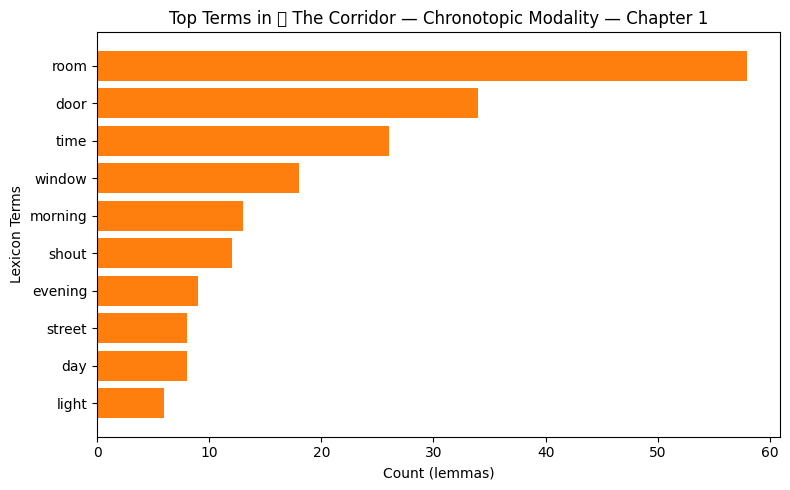

In [66]:
# VISUAL 12B — Top contributing terms for all modalities in a chosen chapter
# -------------------------------------------------------------------------
# Pick a chapter (consistent with per1k)
CH = per1k.index[0]   # ← change to any chapter number you want
TOPN = 10             # how many top terms per modality

# Loop through all modalities defined in LEX
for MOD in LEX.keys():
    # lemma-only words for that modality
    words = set(w for w in LEX[MOD] if " " not in w)
    mask = (TOKENS["chapter"] == CH) & (TOKENS["lemma_l"].isin(words))
    term_counts = (
        TOKENS.loc[mask, "lemma_l"]
              .value_counts()
              .sort_values(ascending=False)
              .head(TOPN)
    )

    # Skip empty modalities for this chapter
    if term_counts.empty:
        print(f"⚠️ No hits for {PRETTY[MOD]} — Chapter {CH}")
        continue

    # Plot top terms for this modality
    plt.figure(figsize=(8,5))
    plt.barh(term_counts.index[::-1], term_counts.values[::-1], color=COLORS[MOD])
    plt.title(f"Top Terms in {PRETTY[MOD]} — Chapter {CH}")
    plt.xlabel("Count (lemmas)")
    plt.ylabel("Lexicon Terms")
    plt.tight_layout()
    plt.savefig(OUT / f"fig_terms_top_{MOD}_ch{CH}.png", dpi=200)
    plt.show()

In [67]:
# ==============================
# TOP TERMS — all chapters, per modality (lemma-only)
# ==============================
import math
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def make_top_terms_all_chapters_for_modality(MOD: str, TOPN: int = 10,
                                             build_grid: bool = True,
                                             build_pdf: bool = True):
    """
    For a given modality key in LEX (e.g., 'Machinery', 'Mirror', 'Loop', 'Beyond', 'Corridor'):
      • Exports per-chapter PNGs of top-terms bars (lemma-only)
      • Optionally exports a grid PNG with all chapters on one page
      • Optionally exports a multi-page PDF (one chart per chapter)
    """
    mod_pretty = PRETTY[MOD]
    mod_color  = COLORS[MOD]
    words = set(w for w in LEX[MOD] if " " not in w)  # lemma-only

    # Output folders
    MOD_DIR = OUT / f"top_terms_{MOD}"
    MOD_DIR.mkdir(parents=True, exist_ok=True)

    # ----- Per-chapter PNGs -----
    chapter_list = list(per1k.index)
    have_any = False

    for CH in chapter_list:
        mask = (TOKENS["chapter"] == CH) & (TOKENS["lemma_l"].isin(words))
        term_counts = (TOKENS.loc[mask, "lemma_l"]
                             .value_counts()
                             .sort_values(ascending=False)
                             .head(TOPN))

        if term_counts.empty:
            # still write an empty placeholder for traceability
            fig = plt.figure(figsize=(6,3))
            plt.title(f"{mod_pretty} — Chapter {CH}\n(no hits)")
            plt.axis("off")
            fig.savefig(MOD_DIR / f"fig_terms_top_{MOD}_ch{CH}.png", dpi=200, bbox_inches="tight")
            plt.close(fig)
            continue

        have_any = True
        fig = plt.figure(figsize=(8,5))
        plt.barh(term_counts.index[::-1], term_counts.values[::-1], color=mod_color)
        plt.title(f"Top Terms — {mod_pretty} (Chapter {CH})")
        plt.xlabel("Count (lemmas)")
        plt.ylabel("Lexicon Terms")
        plt.tight_layout()
        fig.savefig(MOD_DIR / f"fig_terms_top_{MOD}_ch{CH}.png", dpi=200)
        plt.close(fig)

    # If nothing at all, bail early (prevents empty grid/PDF)
    if not have_any:
        print(f"[{MOD}] No hits in any chapter. Wrote empty placeholders only.")
        return

    # ----- Optional: GRID sheet (all chapters on one page) -----
    if build_grid:
        n = len(chapter_list); cols = 5; rows = math.ceil(n/cols)
        fig, axes = plt.subplots(rows, cols, figsize=(3.2*cols, 2.8*rows), squeeze=False)
        for i, CH in enumerate(chapter_list):
            ax = axes[i//cols][i%cols]
            mask = (TOKENS["chapter"] == CH) & (TOKENS["lemma_l"].isin(words))
            term_counts = (TOKENS.loc[mask, "lemma_l"]
                                 .value_counts()
                                 .sort_values(ascending=False)
                                 .head(TOPN))
            if term_counts.empty:
                ax.axis("off"); ax.set_title(f"Ch {CH}: no hits", fontsize=9)
                continue
            ax.barh(term_counts.index[::-1], term_counts.values[::-1], color=mod_color)
            ax.set_title(f"Ch {CH}", fontsize=9)
            ax.set_xticks([]); ax.set_yticks([])
        # hide any unused axes
        for j in range(i+1, rows*cols):
            axes[j//cols][j%cols].axis("off")

        fig.suptitle(f"Top Terms — {mod_pretty} (All Chapters)", y=0.995, fontsize=12)
        plt.tight_layout()
        fig.savefig(MOD_DIR / f"sheet_terms_top_{MOD}_all_chapters.png", dpi=200)
        plt.close(fig)

    # ----- Optional: multi-page PDF -----
    if build_pdf:
        pdf_path = MOD_DIR / f"top_terms_{MOD}__all_chapters.pdf"
        with PdfPages(pdf_path) as pdf:
            for CH in chapter_list:
                mask = (TOKENS["chapter"] == CH) & (TOKENS["lemma_l"].isin(words))
                term_counts = (TOKENS.loc[mask, "lemma_l"]
                                     .value_counts()
                                     .sort_values(ascending=False)
                                     .head(TOPN))
                fig = plt.figure(figsize=(8,5))
                if term_counts.empty:
                    plt.title(f"{mod_pretty} — Chapter {CH}\n(no hits)")
                    plt.axis("off")
                else:
                    plt.barh(term_counts.index[::-1], term_counts.values[::-1], color=mod_color)
                    plt.title(f"Top Terms — {mod_pretty} (Chapter {CH})")
                    plt.xlabel("Count (lemmas)")
                    plt.ylabel("Lexicon Terms")
                    plt.tight_layout()
                pdf.savefig(fig, bbox_inches="tight")
                plt.close(fig)
        print(f"Wrote PDF: {pdf_path.resolve()}")

# ===== Run for all five modalities =====
for MOD in ["Machinery", "Mirror", "Loop", "Beyond", "Corridor"]:
    make_top_terms_all_chapters_for_modality(MOD, TOPN=10, build_grid=True, build_pdf=True)

Wrote PDF: /Users/shikha/Desktop/MTL RESEARCH/out/top_terms_Machinery/top_terms_Machinery__all_chapters.pdf


/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_4776/1046552435.py:52: UserWarning: Glyph 129694 (\N{MIRROR}) missing from current font.
  plt.tight_layout()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_4776/1046552435.py:53: UserWarning: Glyph 129694 (\N{MIRROR}) missing from current font.
  fig.savefig(MOD_DIR / f"fig_terms_top_{MOD}_ch{CH}.png", dpi=200)
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_4776/1046552435.py:52: UserWarning: Glyph 129694 (\N{MIRROR}) missing from current font.
  plt.tight_layout()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_4776/1046552435.py:53: UserWarning: Glyph 129694 (\N{MIRROR}) missing from current font.
  fig.savefig(MOD_DIR / f"fig_terms_top_{MOD}_ch{CH}.png", dpi=200)
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_4776/1046552435.py:52: UserWarning: Glyph 129694 (\N{MIRROR}) missing from current font.
  plt.tight_layout()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_47

Wrote PDF: /Users/shikha/Desktop/MTL RESEARCH/out/top_terms_Mirror/top_terms_Mirror__all_chapters.pdf


/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_4776/1046552435.py:52: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from current font.
  plt.tight_layout()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_4776/1046552435.py:53: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from current font.
  fig.savefig(MOD_DIR / f"fig_terms_top_{MOD}_ch{CH}.png", dpi=200)
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_4776/1046552435.py:52: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from current font.
  plt.tight_layout()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_4776/1046552435.py:53: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from current font.
  fig.savefig(MOD_DIR / f"fig_terms_top_{MOD}_ch{CH}.png", dpi=200)
/var/folders/rg/29160ybs6sq4xj96w06gpd7r00

Wrote PDF: /Users/shikha/Desktop/MTL RESEARCH/out/top_terms_Loop/top_terms_Loop__all_chapters.pdf


/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_4776/1046552435.py:52: UserWarning: Glyph 127756 (\N{MILKY WAY}) missing from current font.
  plt.tight_layout()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_4776/1046552435.py:53: UserWarning: Glyph 127756 (\N{MILKY WAY}) missing from current font.
  fig.savefig(MOD_DIR / f"fig_terms_top_{MOD}_ch{CH}.png", dpi=200)
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_4776/1046552435.py:52: UserWarning: Glyph 127756 (\N{MILKY WAY}) missing from current font.
  plt.tight_layout()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_4776/1046552435.py:53: UserWarning: Glyph 127756 (\N{MILKY WAY}) missing from current font.
  fig.savefig(MOD_DIR / f"fig_terms_top_{MOD}_ch{CH}.png", dpi=200)
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_4776/1046552435.py:52: UserWarning: Glyph 127756 (\N{MILKY WAY}) missing from current font.
  plt.tight_layout()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn

Wrote PDF: /Users/shikha/Desktop/MTL RESEARCH/out/top_terms_Beyond/top_terms_Beyond__all_chapters.pdf


/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_4776/1046552435.py:52: UserWarning: Glyph 128682 (\N{DOOR}) missing from current font.
  plt.tight_layout()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_4776/1046552435.py:53: UserWarning: Glyph 128682 (\N{DOOR}) missing from current font.
  fig.savefig(MOD_DIR / f"fig_terms_top_{MOD}_ch{CH}.png", dpi=200)
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_4776/1046552435.py:52: UserWarning: Glyph 128682 (\N{DOOR}) missing from current font.
  plt.tight_layout()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_4776/1046552435.py:53: UserWarning: Glyph 128682 (\N{DOOR}) missing from current font.
  fig.savefig(MOD_DIR / f"fig_terms_top_{MOD}_ch{CH}.png", dpi=200)
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_4776/1046552435.py:52: UserWarning: Glyph 128682 (\N{DOOR}) missing from current font.
  plt.tight_layout()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_4776/1046552

Wrote PDF: /Users/shikha/Desktop/MTL RESEARCH/out/top_terms_Corridor/top_terms_Corridor__all_chapters.pdf


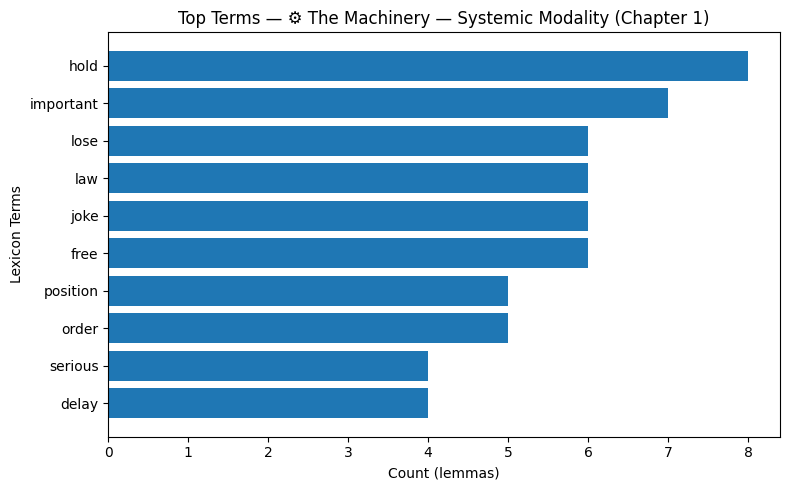

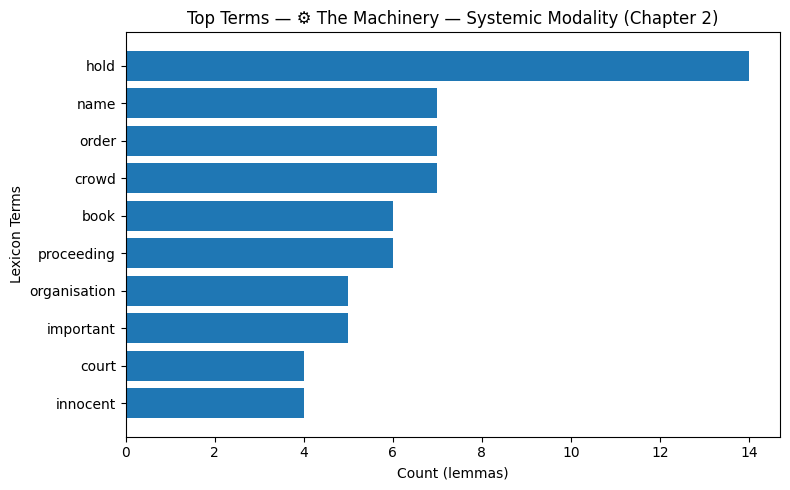

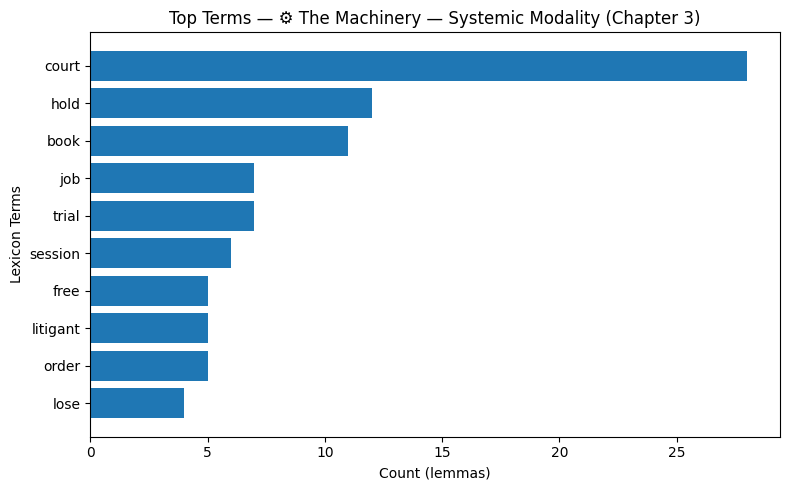

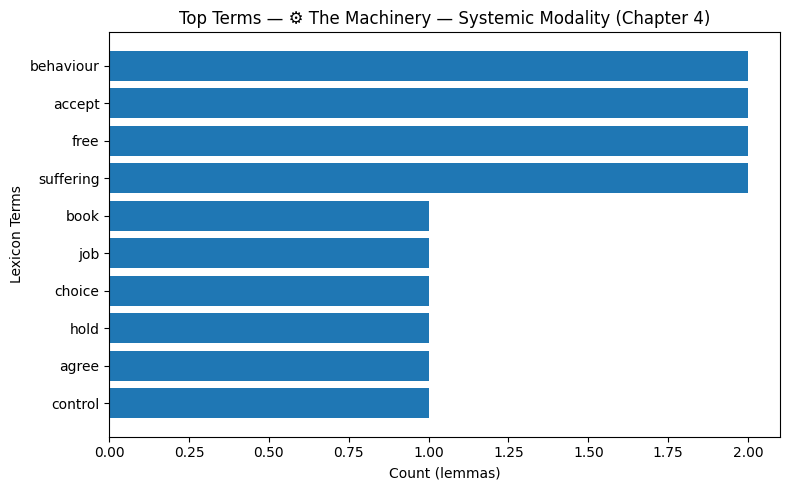

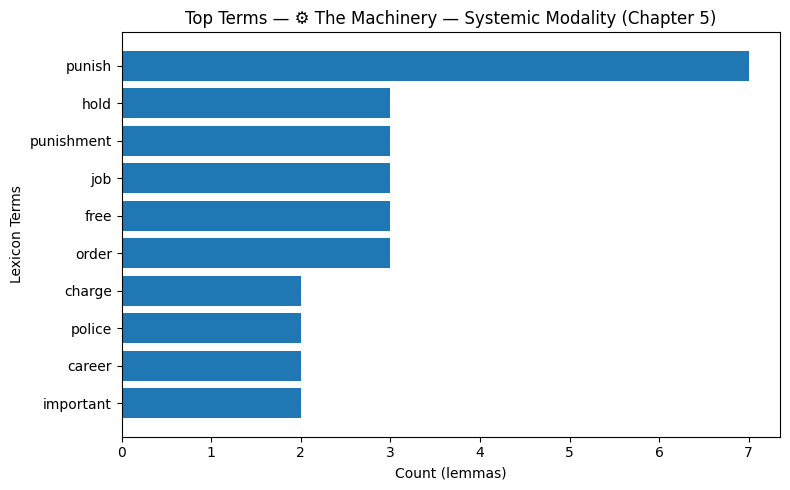

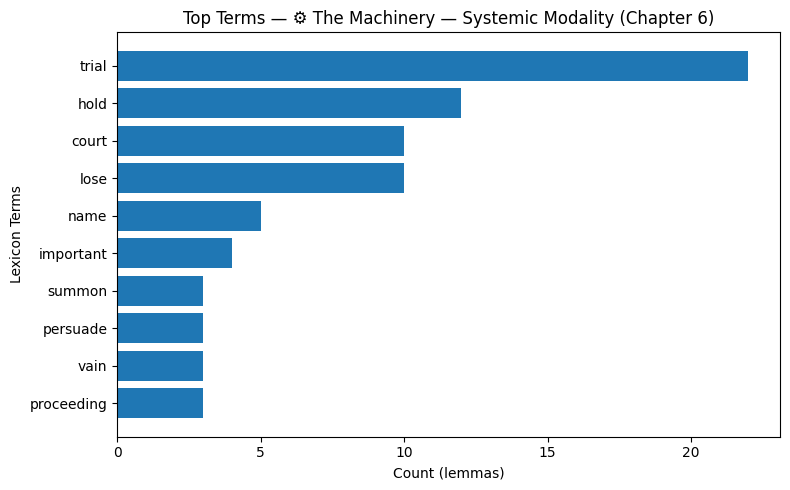

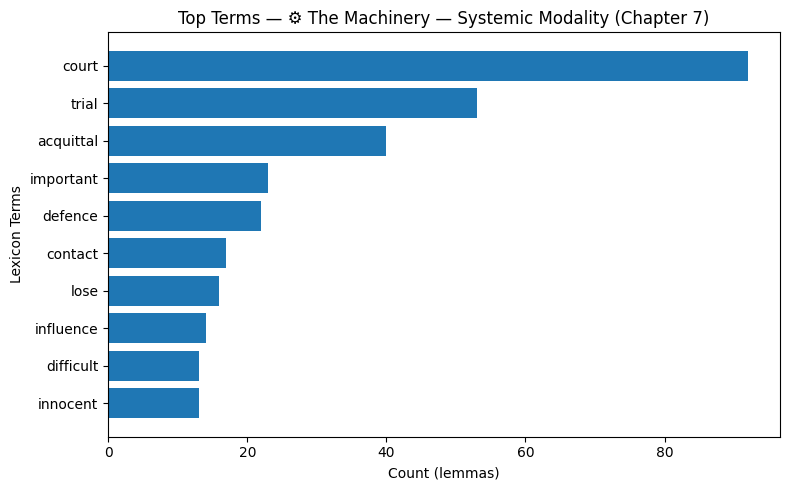

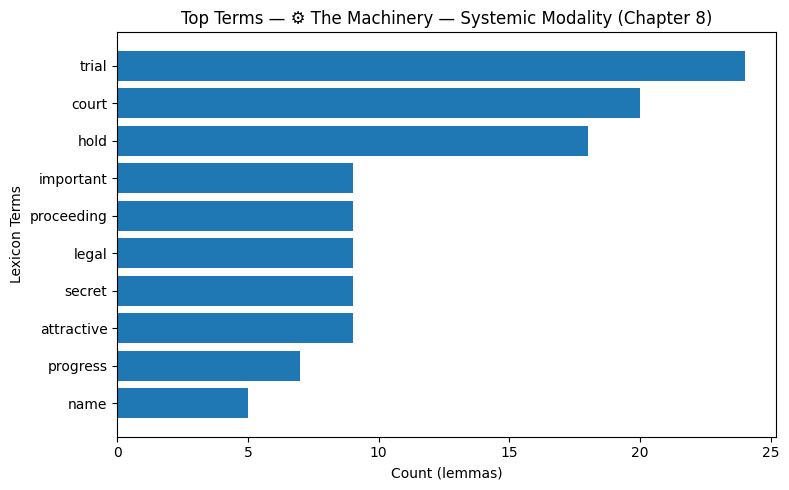

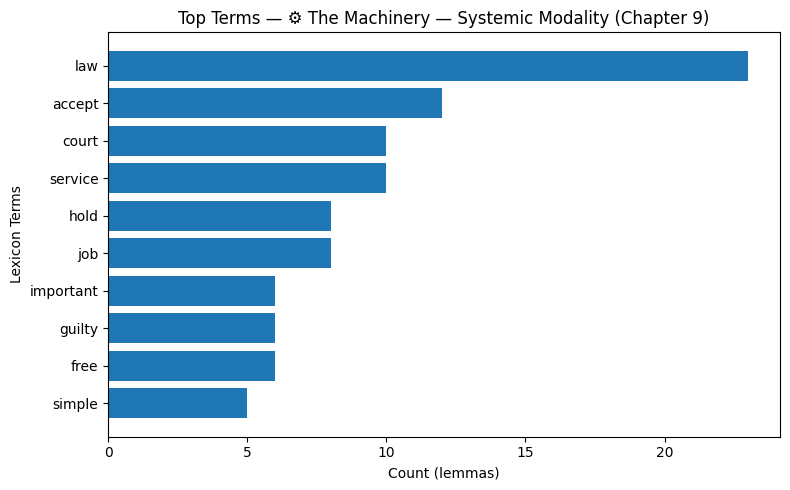

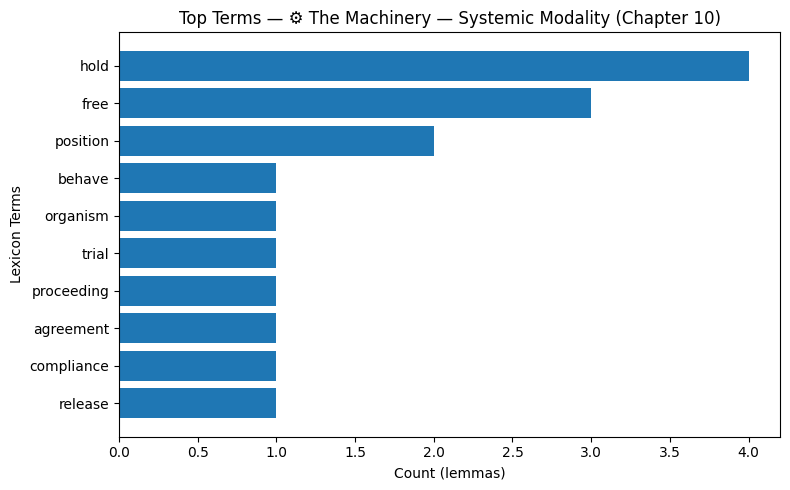

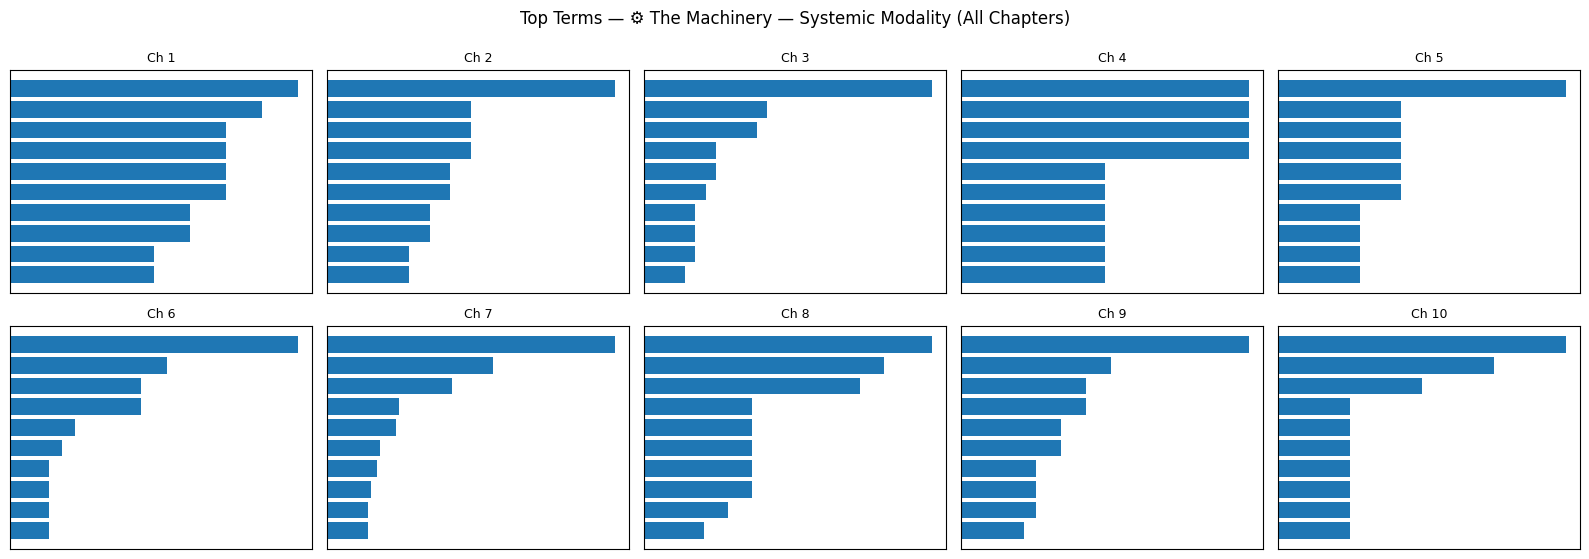

In [68]:
# ==== MACHINERY: Top terms per chapter ====
MOD = "Machinery"
TOPN = 10
GRID = True  # set False to skip the grid sheet

import math
import matplotlib.pyplot as plt

# Per-chapter PNGs
for CH in per1k.index:
    words = set(w for w in LEX[MOD] if " " not in w)
    mask = (TOKENS["chapter"] == CH) & (TOKENS["lemma_l"].isin(words))
    term_counts = (TOKENS.loc[mask, "lemma_l"].value_counts()
                   .sort_values(ascending=False).head(TOPN))

    if term_counts.empty:
        print(f"No hits for {PRETTY[MOD]} — Chapter {CH}")
        continue

    plt.figure(figsize=(8,5))
    plt.barh(term_counts.index[::-1], term_counts.values[::-1], color=COLORS[MOD])
    plt.title(f"Top Terms — {PRETTY[MOD]} (Chapter {CH})")
    plt.xlabel("Count (lemmas)"); plt.ylabel("Lexicon Terms")
    plt.tight_layout(); plt.savefig(OUT / f"fig_terms_top_{MOD}_ch{CH}.png", dpi=200); plt.show()

# Optional: grid sheet (all chapters)
if GRID:
    chs = list(per1k.index)
    n = len(chs); cols = 5; rows = math.ceil(n/cols)
    fig, axes = plt.subplots(rows, cols, figsize=(3.2*cols, 2.8*rows), squeeze=False)
    for i, CH in enumerate(chs):
        ax = axes[i//cols][i%cols]
        words = set(w for w in LEX[MOD] if " " not in w)
        mask = (TOKENS["chapter"] == CH) & (TOKENS["lemma_l"].isin(words))
        term_counts = (TOKENS.loc[mask, "lemma_l"].value_counts()
                       .sort_values(ascending=False).head(TOPN))
        if term_counts.empty:
            ax.axis("off"); ax.set_title(f"Ch {CH}: no hits", fontsize=9); continue
        ax.barh(term_counts.index[::-1], term_counts.values[::-1], color=COLORS[MOD])
        ax.set_title(f"Ch {CH}", fontsize=9); ax.set_xticks([]); ax.set_yticks([])
    # hide any empty axes
    for j in range(i+1, rows*cols):
        axes[j//cols][j%cols].axis("off")
    fig.suptitle(f"Top Terms — {PRETTY[MOD]} (All Chapters)", y=0.99)
    plt.tight_layout(); plt.savefig(OUT / f"sheet_terms_top_{MOD}_all_chapters.png", dpi=200); plt.show()

/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_4776/1894573235.py:84: UserWarning: Glyph 129694 (\N{MIRROR}) missing from current font.
  plt.tight_layout()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_4776/1894573235.py:84: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from current font.
  plt.tight_layout()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_4776/1894573235.py:84: UserWarning: Glyph 127756 (\N{MILKY WAY}) missing from current font.
  plt.tight_layout()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_4776/1894573235.py:84: UserWarning: Glyph 128682 (\N{DOOR}) missing from current font.
  plt.tight_layout()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_4776/1894573235.py:85: UserWarning: Glyph 129694 (\N{MIRROR}) missing from current font.
  plt.savefig(OUT / "fig_top_terms_global_top25.png", dpi=200)
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_4776/1

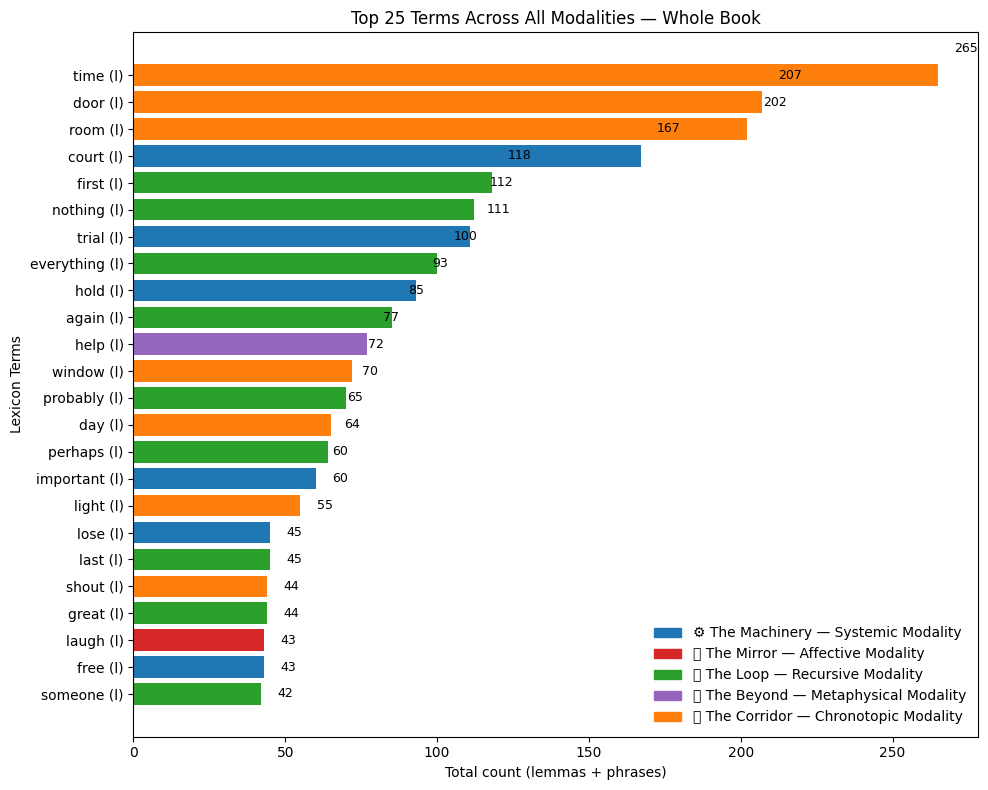

Wrote: /Users/shikha/Desktop/MTL RESEARCH/out/fig_top_terms_global_top25.png
Wrote: /Users/shikha/Desktop/MTL RESEARCH/out/top_terms_global_top25.csv


In [69]:
# GLOBAL TOP TERMS (across all modalities) — Top 25
# -------------------------------------------------
import re
import pandas as pd
import matplotlib.pyplot as plt

TOP_N = 25  # change as needed

def _has_sents():
    try:
        _ = sents  # noqa: F821
        return True
    except NameError:
        return False

def build_global_terms_table():
    rows = []
    for MOD, vocab in LEX.items():
        lemmas = sorted({w.lower() for w in vocab if " " not in w})
        phrases = sorted({w.lower() for w in vocab if " " in w})

        # lemma counts (whole book)
        if lemmas:
            mask = TOKENS["lemma_l"].isin(lemmas)
            ser = TOKENS.loc[mask, "lemma_l"].value_counts()
            if not ser.empty:
                rows.append(pd.DataFrame({
                    "term": ser.index,
                    "count": ser.values,
                    "kind": "lemma",
                    "modality": MOD
                }))

        # phrase counts (whole book, optional)
        if 'INCLUDE_PHRASES' in globals() and INCLUDE_PHRASES and phrases and _has_sents():
            grp = sents["text_l"]  # expect pre-normalized, lowercased
            counts_ph = {}
            for ph in phrases:
                pat = re.compile(re.escape(ph))
                counts_ph[ph] = int(grp.apply(lambda x: len(pat.findall(x))).sum())
            ph_ser = pd.Series(counts_ph)
            ph_ser = ph_ser[ph_ser > 0]
            if not ph_ser.empty:
                rows.append(pd.DataFrame({
                    "term": ph_ser.index,
                    "count": ph_ser.values,
                    "kind": "phrase",
                    "modality": MOD
                }))

    if not rows:
        return pd.DataFrame(columns=["term","count","kind","modality"])

    df = pd.concat(rows, ignore_index=True)
    # if same term appears multiple times within a modality (lemma/phrase), sum it
    df = (df.groupby(["modality","term"], as_index=False)
            .agg({"count":"sum", "kind":"first"}))
    return df.sort_values("count", ascending=False)

global_terms = build_global_terms_table()
topN = global_terms.sort_values("count", ascending=False).head(TOP_N).copy()

# ---- Plot: single horizontal bar chart, colored by modality ----
plt.figure(figsize=(10, 8))
topN = topN.sort_values("count", ascending=True)  # small→large for barh
colors = [COLORS[m] for m in topN["modality"]]
labels = [f"{t} ({k[0]})" for t, k in zip(topN["term"], topN["kind"])]

plt.barh(labels, topN["count"].values, color=colors)

# annotate counts
maxv = topN["count"].max() if not topN.empty else 0
for i, v in enumerate(topN["count"].values):
    plt.text(v + (0.02*maxv if maxv else 0.5), i, str(int(v)), va="center", fontsize=9)

plt.title("Top 25 Terms Across All Modalities — Whole Book")
plt.xlabel("Total count (lemmas + phrases)"); plt.ylabel("Lexicon Terms")

# legend by modality (consistent order)
import matplotlib.patches as mpatches
handles = [mpatches.Patch(color=COLORS[k], label=PRETTY[k]) for k in LEX.keys()]
plt.legend(handles=handles, loc="lower right", frameon=False)

plt.tight_layout()
plt.savefig(OUT / "fig_top_terms_global_top25.png", dpi=200)
plt.show()

# CSV for appendix / reproducibility
topN.sort_values("count", ascending=False)[["term","kind","modality","count"]] \
    .to_csv(OUT / "top_terms_global_top25.csv", index=False)

print("Wrote:", (OUT / "fig_top_terms_global_top25.png").resolve())
print("Wrote:", (OUT / "top_terms_global_top25.csv").resolve())

/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_4776/2123380863.py:85: UserWarning: Glyph 129694 (\N{MIRROR}) missing from current font.
  plt.tight_layout()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_4776/2123380863.py:85: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from current font.
  plt.tight_layout()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_4776/2123380863.py:85: UserWarning: Glyph 127756 (\N{MILKY WAY}) missing from current font.
  plt.tight_layout()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_4776/2123380863.py:85: UserWarning: Glyph 128682 (\N{DOOR}) missing from current font.
  plt.tight_layout()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_4776/2123380863.py:86: UserWarning: Glyph 129694 (\N{MIRROR}) missing from current font.
  plt.savefig(OUT/"fig_top_terms_global.png", dpi=200)
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_4776/212338086

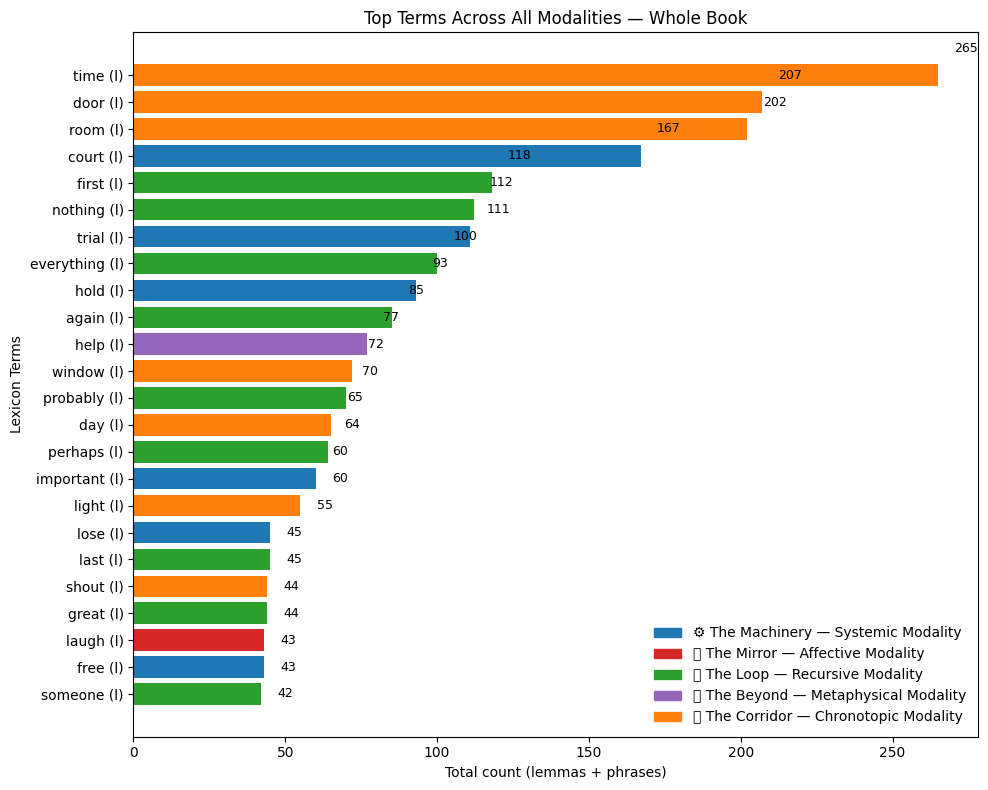

Wrote: /Users/shikha/Desktop/MTL RESEARCH/out/fig_top_terms_global.png
Wrote: /Users/shikha/Desktop/MTL RESEARCH/out/top_terms_global.csv


In [70]:
# ONE GRAPH: Global top terms across all categories (whole book)
# -------------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

TOP_N = 25  # change to 15/20/etc.

def build_global_term_table():
    rows = []
    for mod, vocab in LEX.items():
        lemmas = sorted({w.lower() for w in vocab if " " not in w})
        phrases = sorted({w.lower() for w in vocab if " " in w})

        # lemma counts (whole book)
        if lemmas:
            mask = TOKENS["lemma_l"].isin(lemmas)
            ser = TOKENS.loc[mask, "lemma_l"].value_counts()
            if not ser.empty:
                rows.append(pd.DataFrame({
                    "term": ser.index,
                    "count": ser.values,
                    "kind": "lemma",
                    "modality": mod
                }))

        # phrase counts (whole book, optional)
        if INCLUDE_PHRASES and phrases:
            # combine all sentences to 1 series for speed
            grp = sents["text_l"]
            counts_ph = {}
            for ph in phrases:
                pat = re.compile(re.escape(ph))
                counts_ph[ph] = int(grp.apply(lambda x: len(pat.findall(x))).sum())
            ph_ser = pd.Series(counts_ph)
            ph_ser = ph_ser[ph_ser > 0]
            if not ph_ser.empty:
                rows.append(pd.DataFrame({
                    "term": ph_ser.index,
                    "count": ph_ser.values,
                    "kind": "phrase",
                    "modality": mod
                }))

    if rows:
        df = pd.concat(rows, ignore_index=True)
        # if a term appears in both lemma/phrase (rare), keep the max per modality-term
        df = (df.groupby(["modality","term"], as_index=False)
                .agg({"count":"sum","kind":"first"}))
        return df.sort_values("count", ascending=False)
    return pd.DataFrame(columns=["term","count","kind","modality"])

global_terms = build_global_term_table()

# pick the global top N (irrespective of modality), keeping their modality for color/legend
topN = (global_terms.sort_values("count", ascending=False)
                    .head(TOP_N)
                    .copy())

# ---- Plot: single horizontal bar chart, colored by modality ----
plt.figure(figsize=(10, 8))
# order small->large for nicer bars
topN = topN.sort_values("count", ascending=True)
colors = [COLORS[m] for m in topN["modality"]]

labels = [f"{t} ({k[0]})" for t, k in zip(topN["term"], topN["kind"])]
plt.barh(labels, topN["count"].values, color=colors)

# annotate values
for i, v in enumerate(topN["count"].values):
    plt.text(v + max(topN["count"].values)*0.02 if len(topN) else 0.1,
             i, str(v), va="center", fontsize=9)

plt.title("Top Terms Across All Modalities — Whole Book")
plt.xlabel("Total count (lemmas + phrases)")
plt.ylabel("Lexicon Terms")

# legend by modality
# build unique handles in the order of LEX keys
import matplotlib.patches as mpatches
handles = [mpatches.Patch(color=COLORS[k], label=PRETTY[k]) for k in LEX.keys()]
plt.legend(handles=handles, loc="lower right", frameon=False)

plt.tight_layout()
plt.savefig(OUT/"fig_top_terms_global.png", dpi=200)
plt.show()

# also write a CSV for the figure’s data (helpful for the appendix)
topN[["term","kind","modality","count"]].sort_values("count", ascending=False) \
    .to_csv(OUT/"top_terms_global.csv", index=False)
print("Wrote:", (OUT/"fig_top_terms_global.png").resolve())
print("Wrote:", (OUT/"top_terms_global.csv").resolve())

In [29]:
import pandas as pd

# Simple lemma-based global term table, ignoring phrases
rows = []

# If you already have a lemma-aligned dictionary, use it
if "LEX_UNIG_LEMMA" in globals():
    lex_source = LEX_UNIG_LEMMA   # modality -> list of lemmas (already aligned)
else:
    # fallback: derive lemmas by lowercasing single-word entries from LEX
    lex_source = {
        mod: sorted({str(w).strip().lower() for w in vocab if " " not in str(w)})
        for mod, vocab in LEX.items()
    }

for mod, lemmas in lex_source.items():
    if not lemmas:
        continue

    # count lemma frequencies in the whole book
    mask = TOKENS["lemma_l"].isin(lemmas)
    vc = TOKENS.loc[mask, "lemma_l"].value_counts()

    if vc.empty:
        continue

    df_mod = pd.DataFrame({
        "term": vc.index,
        "count": vc.values,
    })
    df_mod["kind"] = "lemma"
    df_mod["modality"] = mod
    rows.append(df_mod)

if rows:
    global_terms = pd.concat(rows, ignore_index=True)
    global_terms = global_terms.sort_values("count", ascending=False)
else:
    global_terms = pd.DataFrame(columns=["term", "count", "kind", "modality"])

print("Global terms by modality:")
print(global_terms["modality"].value_counts())

Global terms by modality:
modality
Machinery    153
Mirror        67
Corridor      59
Loop          32
Beyond        20
Name: count, dtype: int64


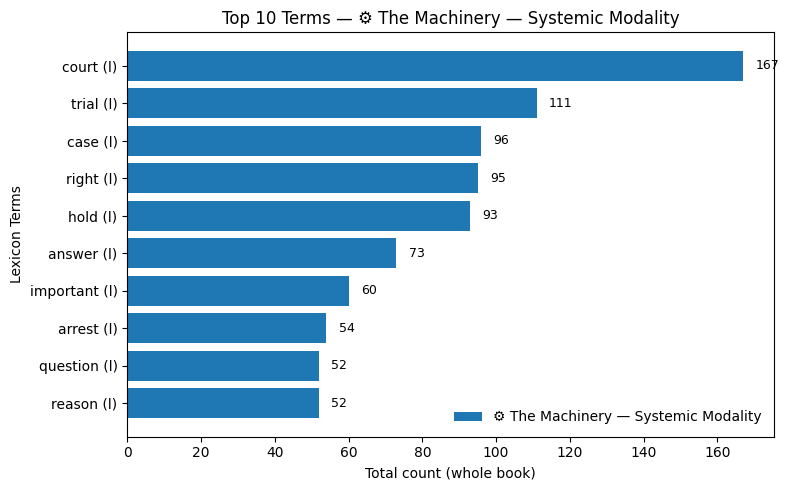

Wrote: /Users/shikha/Desktop/MTL RESEARCH/out/fig_top_terms_machinery.png


/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_1473/1361271258.py:34: UserWarning: Glyph 129694 (\N{MIRROR}) missing from current font.
  plt.tight_layout()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_1473/1361271258.py:36: UserWarning: Glyph 129694 (\N{MIRROR}) missing from current font.
  plt.savefig(out_path, dpi=200)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129694 (\N{MIRROR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


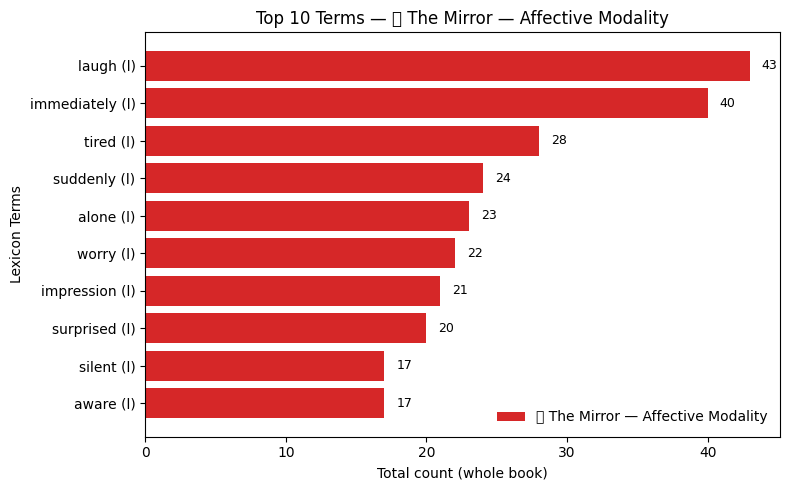

/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_1473/1361271258.py:34: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from current font.
  plt.tight_layout()


Wrote: /Users/shikha/Desktop/MTL RESEARCH/out/fig_top_terms_mirror.png


/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_1473/1361271258.py:36: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from current font.
  plt.savefig(out_path, dpi=200)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


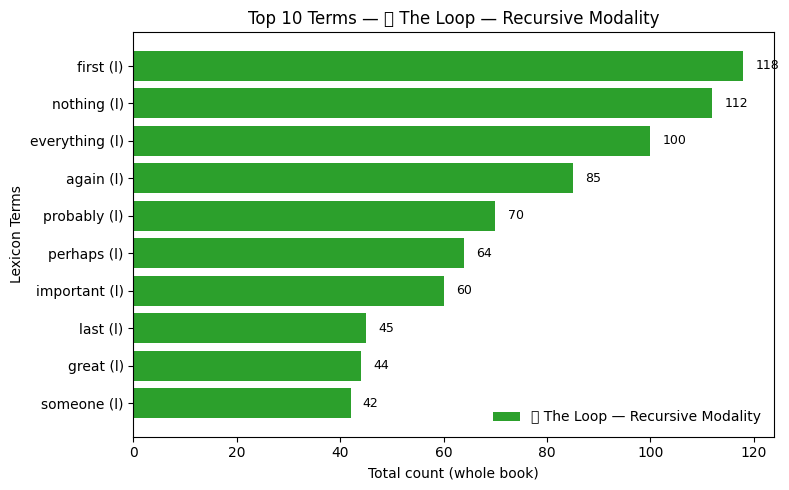

Wrote: /Users/shikha/Desktop/MTL RESEARCH/out/fig_top_terms_loop.png


/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_1473/1361271258.py:34: UserWarning: Glyph 127756 (\N{MILKY WAY}) missing from current font.
  plt.tight_layout()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_1473/1361271258.py:36: UserWarning: Glyph 127756 (\N{MILKY WAY}) missing from current font.
  plt.savefig(out_path, dpi=200)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127756 (\N{MILKY WAY}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


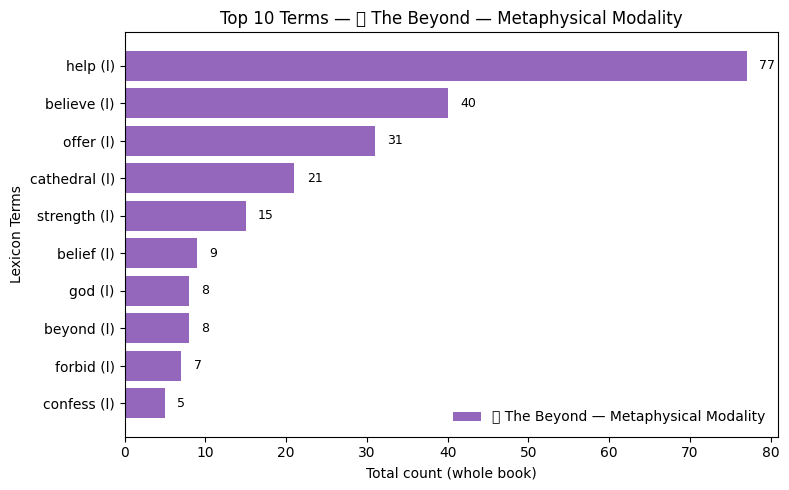

/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_1473/1361271258.py:34: UserWarning: Glyph 128682 (\N{DOOR}) missing from current font.
  plt.tight_layout()
/var/folders/rg/29160ybs6sq4xj96w06gpd7r0000gn/T/ipykernel_1473/1361271258.py:36: UserWarning: Glyph 128682 (\N{DOOR}) missing from current font.
  plt.savefig(out_path, dpi=200)


Wrote: /Users/shikha/Desktop/MTL RESEARCH/out/fig_top_terms_beyond.png


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128682 (\N{DOOR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


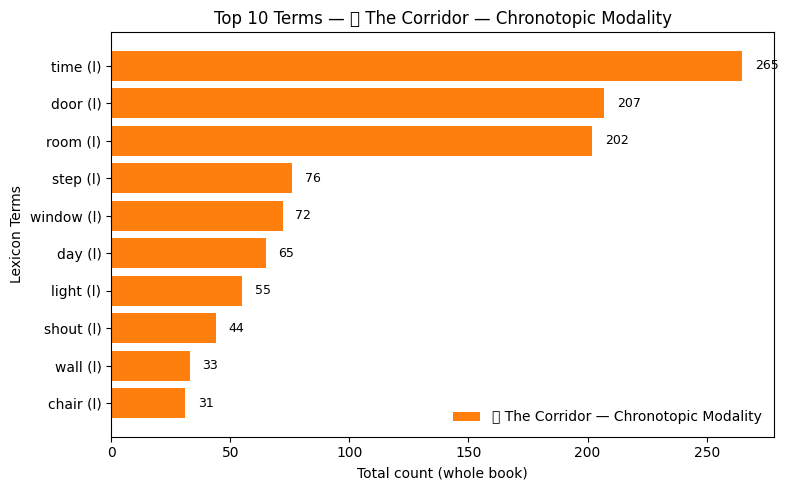

Wrote: /Users/shikha/Desktop/MTL RESEARCH/out/fig_top_terms_corridor.png


In [30]:
# =========================================
# TOP 10 TERMS IN EACH MODALITY (5 PLOTS)
# =========================================
TOP_N_PER_MOD = 10  # change if you want more/less

for mod in LEX.keys():  # keeps your modality order
    sub = global_terms[global_terms["modality"] == mod].copy()
    if sub.empty:
        continue

    # take top N by frequency
    sub = sub.sort_values("count", ascending=False).head(TOP_N_PER_MOD)
    # sort small->large so big bar at bottom
    sub = sub.sort_values("count", ascending=True)

    plt.figure(figsize=(8, 5))

    labels = [f"{t} ({k[0]})" for t, k in zip(sub["term"], sub["kind"])]
    plt.barh(labels, sub["count"].values, color=COLORS[mod])

    # annotate counts
    max_count = sub["count"].max()
    for i, v in enumerate(sub["count"].values):
        plt.text(v + max_count * 0.02,
                 i, str(v), va="center", fontsize=9)

    plt.title(f"Top {TOP_N_PER_MOD} Terms — {PRETTY.get(mod, mod)}")
    plt.xlabel("Total count (whole book)")
    plt.ylabel("Lexicon Terms")

    # simple legend with modality name
    plt.legend([PRETTY.get(mod, mod)], frameon=False, loc="lower right")

    plt.tight_layout()
    out_path = OUT / f"fig_top_terms_{mod.lower()}.png"
    plt.savefig(out_path, dpi=200)
    plt.show()
    print("Wrote:", out_path.resolve())

In [ ]:
#PART 2 RELATIONAL MODELING THROUGH NETWORK ANALYSIS

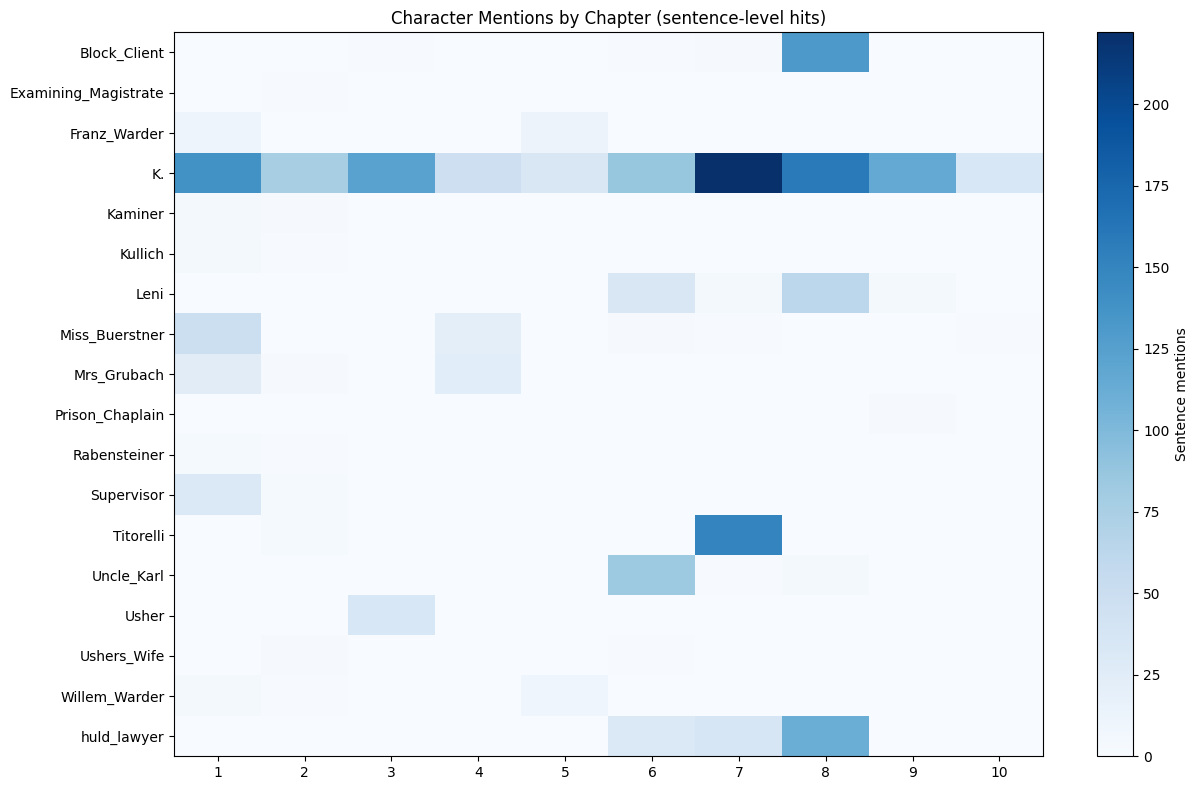


Total sentence mentions of K.: 1034


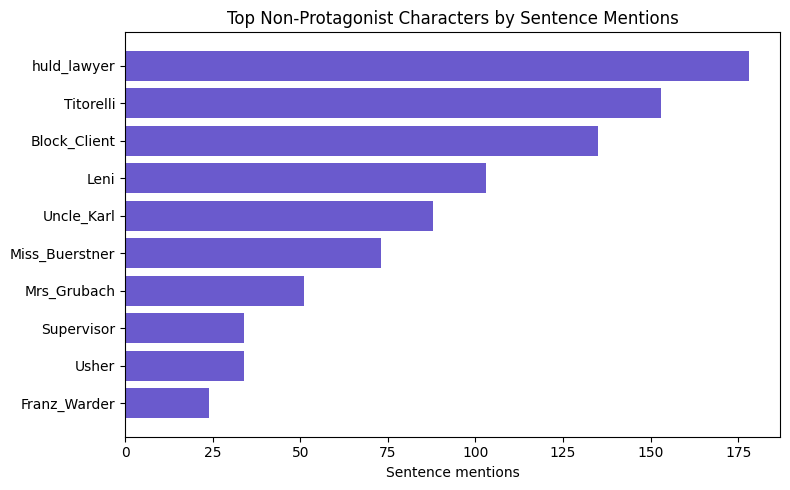

Wrote: /Users/shikha/Desktop/MTL RESEARCH/out/fig_char_mentions_topbar_others.png


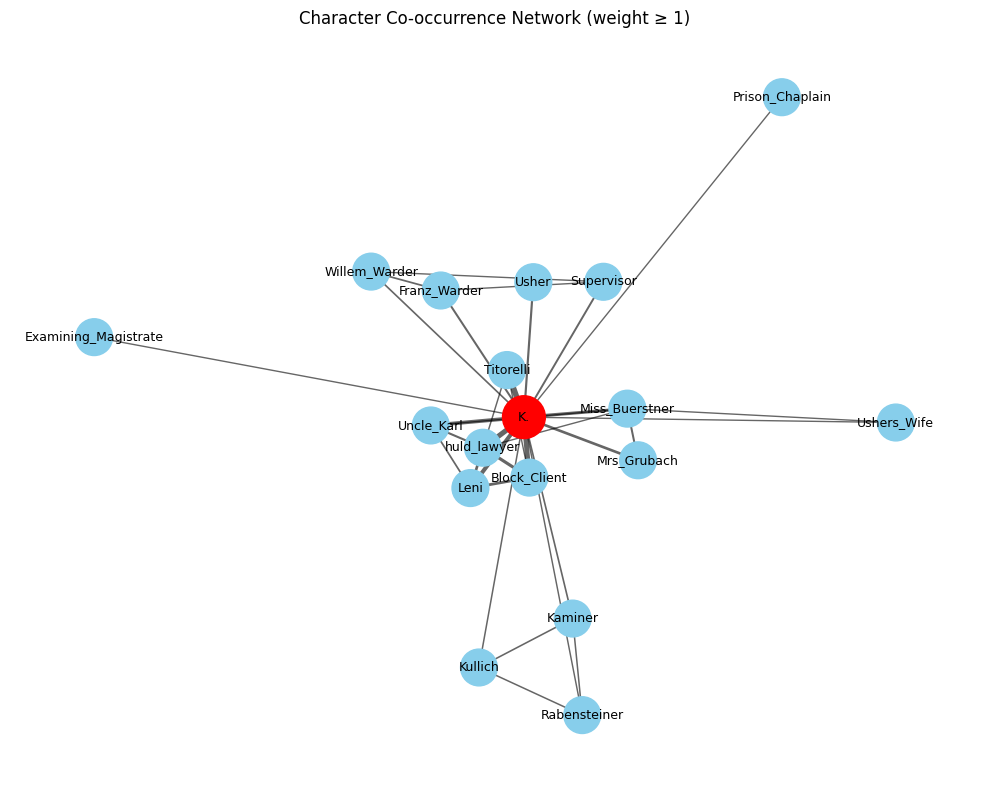

✅ Rebuilt mentions & network with robust K. matching.
   Files:
  - char_mentions_by_chapter.csv
  - fig_char_mentions_heatmap.png
  - fig_char_mentions_topbar.png
  - cooccurrence_edgelist.csv
  - fig_cooccurrence_network.png


In [36]:
# =============================
# FIXED: Normalization + Mentions + Network (captures ALL K. links)
# =============================
import re
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from pathlib import Path

BASE = Path("data")
OUT  = Path("out"); OUT.mkdir(exist_ok=True)

df_sents = pd.read_csv(BASE / "sentences.csv")

# --- 1) Normalize punctuation/quotes first (helps regex robustness) ---
def norm_quotes(s: str) -> str:
    if not isinstance(s, str): 
        return s
    return (s
        .replace("’","'").replace("‘","'")
        .replace("“",'"').replace("”",'"')
        .replace("—","-").replace("–","-")
    )

df_sents["text_norm"] = df_sents["text"].astype(str).map(norm_quotes)

# --- 2) Your existing mappings (trimmed for brevity; keep yours) ---
PROTAGONIST_PATTERNS = [
    # Fold possessive to canonical "K." so we only match one canonical form
    (r"(?i)\bJosef\s+K\.\s*['’]s\b", "K."),
    (r"(?i)\bJoseph\s+K\.\s*['’]s\b", "K."),
    (r"(?i)\bJosef\s+K\.\b", "K."),
    (r"(?i)\bJoseph\s+K\.\b", "K."),
    (r"(?i)\bJosef\s+K\b", "K."),   # sometimes dot is missing in some texts
    (r"(?i)\bJoseph\s+K\b", "K."),
    # Also fold K.'s → K.
    (r"(?i)\bK\.\s*['’]s\b", "K."),
]

CONTEXT_RULES = [
    (r"(?i)\bK\.\s*['’]s\s+uncle\b", "Uncle_Karl"),
    (r"(?i)\bUncle\s+Karl\b", "Uncle_Karl"),
    (r"(?i)\bBlock,\s+the\s+business\s*-?\s*man\b", "Block_Client"),
    (r"(?i)\b(?:the\s+)?business\s*-?\s*man\s+Block\b", "Block_Client"),
    (r"(?i)\b(?:business\s*-?\s*man)\s+Block['’]s\b", "Block_Client"),
]

NAME_MAP_CI = {
    r"(?i)\bMrs\.?\s+Grubach\b": "Mrs_Grubach",
    r"(?i)\bFrau\s+Grubach\b": "Mrs_Grubach",
    r"(?i)\bMiss\s+B[üu]rstner\b": "Miss_Buerstner",
    r"(?i)\bFr[äa]ulein\s+B[üu]rstner\b": "Miss_Buerstner",
    r"(?i)\bFranz\b": "Franz_Warder",
    r"(?i)\bWillem\b": "Willem_Warder",
    r"(?i)\bExamining\s+Magistrate\b": "Examining_Magistrate",
    r"(?i)\bInvestigating\s+Judge\b": "Examining_Magistrate",
    r"(?i)\bSupervisor\b": "Supervisor",
    r"(?i)\bUsher\b": "Usher",
    r"(?i)\bLawyer\s+Huld\b": "huld_lawyer",
    r"(?i)\bAdvocate\s+Huld\b": "huld_lawyer",
    r"(?i)\bthe\s+lawyer\b": "huld_lawyer",
    r"(?i)\bHuld\b": "huld_lawyer",
    r"(?i)\bLeni\b": "Leni",
    r"(?i)\bthe\s+carer\b": "Leni",
    r"(?i)\bcarer\b": "Leni",
    r"(?i)\bTitorelli\b": "Titorelli",
    r"(?i)\bthe\s+painter\b": "Titorelli",
    r"(?i)\bpainter\b": "Titorelli",
    r"(?i)\bChaplain\b": "Prison_Chaplain",
    r"(?i)\bUncle\b": "Uncle_Karl",
    r"(?i)\bRudi\b": "Block_Client",
    r"(?i)\bBlock\b": "Block_Client",
    r"(?i)\bbusiness\s*-?\s*man\b": "Block_Client",
    r"(?i)\bUsher['’]s\s+wife\b": "Ushers_Wife",
    r"(?i)\bthe\s+washerwoman\b": "Ushers_Wife",
    r"(?i)\bwasherwoman\b": "Ushers_Wife",
    r"(?i)\bRabensteiner\b": "Rabensteiner",
    r"(?i)\bKullich\b": "Kullich",
    r"(?i)\bKaminer\b": "Kaminer",
}

CANONICAL_SET = {
    "K.",
    "Uncle_Karl",
    "Mrs_Grubach",
    "Miss_Buerstner",
    "Franz_Warder",
    "Willem_Warder",
    "Examining_Magistrate",
    "Supervisor",
    "Usher",
    "Ushers_Wife",
    "huld_lawyer",
    "Leni",
    "Titorelli",
    "Prison_Chaplain",
    "Block_Client",
    "Rabensteiner",
    "Kullich",
    "Kaminer",
}

def apply_name_normalization(s: str) -> str:
    if not isinstance(s, str): 
        return s
    out = s
    # protagonist first (including possessive -> K.)
    for pat, rep in PROTAGONIST_PATTERNS:
        out = re.sub(pat, rep, out)
    # context-driven
    for pat, rep in CONTEXT_RULES:
        out = re.sub(pat, rep, out)
    # explicit name maps
    for pat, rep in NAME_MAP_CI.items():
        out = re.sub(pat, rep, out)
    return out

df_sents["text_norm"] = df_sents["text_norm"].apply(apply_name_normalization)

# --- 3) Build a robust per-name matcher ---
# Most names can use word boundaries. "K." needs a special pattern.
special_patterns = {
    "K.": re.compile(r"(?<!\w)K\.(?:['’]s)?(?!\w)")  # matches K., K.’s, K's
    # If your text sometimes has bare "K" (no dot), add:
    # "K.": re.compile(r"(?<!\w)K(?:\.(?:['’]s)?)?(?!\w)")
}

generic_patterns = {
    name: re.compile(rf"(?<!\w){re.escape(name)}(?!\w)")
    for name in CANONICAL_SET if name != "K."
}

def extract_mentions(s: str):
    found = set()
    if not isinstance(s, str): 
        return found
    # K. first
    if special_patterns["K."].search(s):
        found.add("K.")
    # Others
    for name, pat in generic_patterns.items():
        if pat.search(s):
            found.add(name)
    return found

# ========== Mentions by chapter ==========
sent_mentions = (
    df_sents[["chapter","chapter_title","sent_id","text_norm"]]
    .assign(mentions=lambda d: d["text_norm"].apply(extract_mentions))
)

rows = []
for _, r in sent_mentions.iterrows():
    for chname in r["mentions"]:
        rows.append((r["chapter"], r["chapter_title"], r["sent_id"], chname))
char_sents = pd.DataFrame(rows, columns=["chapter","chapter_title","sent_id","character"])

char_counts = (
    char_sents.groupby(["chapter","chapter_title","character"])
    .size().rename("mention_sents").reset_index()
)

pivot = (char_counts
         .pivot(index=["chapter","chapter_title"], columns="character", values="mention_sents")
         .fillna(0).astype(int)
         .sort_index(level=0))

pivot.to_csv(OUT / "char_mentions_by_chapter.csv")

# --- Heatmap ---
plt.figure(figsize=(min(18, 2 + 0.6*len(pivot.columns)), 8))
mat = pivot.values.T
plt.imshow(mat, aspect="auto", cmap="Blues")
plt.colorbar(label="Sentence mentions")
plt.yticks(ticks=np.arange(mat.shape[0]), labels=pivot.columns)
plt.xticks(ticks=np.arange(mat.shape[1]), labels=pivot.index.get_level_values("chapter"))
plt.title("Character Mentions by Chapter (sentence-level hits)")
plt.tight_layout()
plt.savefig(OUT / "fig_char_mentions_heatmap.png", dpi=200)
plt.show()

# # --- Top characters bar ---
# totals = pivot.sum(axis=0).sort_values(ascending=False).head(12)
# plt.figure(figsize=(8,5))
# plt.barh(totals.index[::-1], totals.values[::-1])
# plt.title("Top Characters by Sentence Mentions")
# plt.xlabel("Sentence mentions")
# plt.tight_layout()
# plt.savefig(OUT / "fig_char_mentions_topbar.png", dpi=200)
# plt.show()

# --- Top characters bar (excluding K. so scale is readable) ---
totals = pivot.sum(axis=0).sort_values(ascending=False)

k_count = totals.get("K.", 0)
print(f"\nTotal sentence mentions of K.: {k_count}")

# Drop K. from the bar chart, keep next top 10
others = totals.drop(labels=["K."], errors="ignore").head(10)

plt.figure(figsize=(8, 5))
plt.barh(others.index[::-1], others.values[::-1], color="slateblue")
plt.title("Top Non-Protagonist Characters by Sentence Mentions")
plt.xlabel("Sentence mentions")
plt.tight_layout()
plt.savefig(OUT / "fig_char_mentions_topbar_others.png", dpi=200)
plt.show()

print("Wrote:", (OUT / "fig_char_mentions_topbar_others.png").resolve())

# ========== Co-occurrence network (no hard threshold; show all, then filter if needed) ==========
edges = {}
for _, r in sent_mentions.iterrows():
    chars = sorted(list(r["mentions"]))
    if len(chars) < 2:
        continue
    for a, b in itertools.combinations(chars, 2):
        edges[(a,b)] = edges.get((a,b), 0) + 1

edgelist = (pd.DataFrame([{"source": a, "target": b, "weight": w} for (a,b), w in edges.items()])
            .sort_values("weight", ascending=False))
edgelist.to_csv(OUT / "cooccurrence_edgelist.csv", index=False)

# If graph is too dense, set a higher min_weight (e.g., 2 or 3)
min_weight = 1  # ← **key change**: keep K.'s ties visible
G = nx.Graph()
for _, row in edgelist.iterrows():
    if row["weight"] >= min_weight:
        G.add_edge(row["source"], row["target"], weight=row["weight"])

plt.figure(figsize=(10,8))
pos = nx.spring_layout(G, seed=42)
weights = np.array([G[u][v]["weight"] for u,v in G.edges()])
if len(weights) == 0:
    edge_widths = []
else:
    edge_widths = 1 + (weights - weights.min())/(weights.max()-weights.min()+1e-9)*3


# --- color & size: highlight K. in red ---
node_colors = []
node_sizes = []
for n in G.nodes():
    if n == "K.":          # or whatever your canonical label for K is
        node_colors.append("red")
        node_sizes.append(950)   # bigger node for K
    else:
        node_colors.append("#87ceeb")
        node_sizes.append(700)

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors)
nx.draw_networkx_labels(G, pos, font_size=9)
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.6)
plt.title(f"Character Co-occurrence Network (weight ≥ {min_weight})")
plt.axis("off")
plt.tight_layout()
plt.savefig(OUT / "fig_cooccurrence_network.png", dpi=200)
plt.show()

print("✅ Rebuilt mentions & network with robust K. matching.")
print("   Files:\n  - char_mentions_by_chapter.csv\n  - fig_char_mentions_heatmap.png\n  - fig_char_mentions_topbar.png\n  - cooccurrence_edgelist.csv\n  - fig_cooccurrence_network.png")

In [72]:
# ============================
# PER-CHAPTER CO-OCCURRENCE EDGES
# ============================
# We reuse `sent_mentions`, which has:
#   chapter, chapter_title, sent_id, text_norm, mentions (set of canonical names)

chapter_edge_rows = []

for (ch, ch_title), group in sent_mentions.groupby(["chapter", "chapter_title"]):
    # For each sentence in this chapter, get the characters in that sentence
    for _, row in group.iterrows():
        chars = sorted(list(row["mentions"]))
        if len(chars) < 2:
            continue
        # All unordered pairs in this sentence
        for a, b in itertools.combinations(chars, 2):
            chapter_edge_rows.append({
                "chapter": ch,
                "chapter_title": ch_title,
                "source": a,
                "target": b,
                "sent_id": row["sent_id"],
            })

chapter_edges = pd.DataFrame(chapter_edge_rows)

# Aggregate: how many sentences in chapter where (a,b) co-occur
chapter_edgelist = (
    chapter_edges
      .groupby(["chapter", "chapter_title", "source", "target"])
      .size()
      .rename("weight")
      .reset_index()
)

chapter_edgelist.to_csv(OUT / "cooccurrence_edgelist_by_chapter.csv", index=False)
print(chapter_edgelist.head())

   chapter chapter_title        source         target  weight
0        1   Chapter One  Franz_Warder             K.       5
1        1   Chapter One  Franz_Warder     Supervisor       1
2        1   Chapter One  Franz_Warder  Willem_Warder       2
3        1   Chapter One            K.        Kaminer       4
4        1   Chapter One            K.        Kullich       3


In [73]:
# ============================
# PER-CHAPTER CO-OCCURRENCE EDGES
# ============================
# We reuse `sent_mentions`, which has:
#   chapter, chapter_title, sent_id, text_norm, mentions (set of canonical names)

chapter_edge_rows = []

for (ch, ch_title), group in sent_mentions.groupby(["chapter", "chapter_title"]):
    # For each sentence in this chapter, get the characters in that sentence
    for _, row in group.iterrows():
        chars = sorted(list(row["mentions"]))
        if len(chars) < 2:
            continue
        # All unordered pairs in this sentence
        for a, b in itertools.combinations(chars, 2):
            chapter_edge_rows.append({
                "chapter": ch,
                "chapter_title": ch_title,
                "source": a,
                "target": b,
                "sent_id": row["sent_id"],
            })

chapter_edges = pd.DataFrame(chapter_edge_rows)

# Aggregate: how many sentences in chapter where (a,b) co-occur
chapter_edgelist = (
    chapter_edges
      .groupby(["chapter", "chapter_title", "source", "target"])
      .size()
      .rename("weight")
      .reset_index()
)

chapter_edgelist.to_csv(OUT / "cooccurrence_edgelist_by_chapter.csv", index=False)
print(chapter_edgelist.head())

   chapter chapter_title        source         target  weight
0        1   Chapter One  Franz_Warder             K.       5
1        1   Chapter One  Franz_Warder     Supervisor       1
2        1   Chapter One  Franz_Warder  Willem_Warder       2
3        1   Chapter One            K.        Kaminer       4
4        1   Chapter One            K.        Kullich       3


In [74]:
# ============================
# GLOBAL LAYOUT FOR CONSISTENT POSITIONS
# ============================
# If you already built G and pos earlier, you can reuse those directly.
# Otherwise we rebuild a global graph from the overall `edgelist`.

G_global = nx.Graph()
for _, row in edgelist.iterrows():
    G_global.add_edge(row["source"], row["target"], weight=row["weight"])

# Compute layout once; re-use for all chapter subgraphs
pos_global = nx.spring_layout(G_global, seed=42)  # deterministic layout

# Sanity check: ensure we have a position for each canonical character
missing_pos = CANONICAL_SET - set(pos_global.keys())
if missing_pos:
    print("⚠️ Some canonical names not in global graph (no pos assigned):", missing_pos)

In [75]:
def draw_chapter_network(chapter_num, min_weight=1):
    """
    Draw and save a network plot for a single chapter.
    - If the chapter has co-occurrence edges, we draw the usual network.
    - If there are NO edges but K. appears, we draw a single red node for K.
    """
    # 1) Filter the edgelist to this chapter
    sub_edges = chapter_edgelist[chapter_edgelist["chapter"] == chapter_num]
    if min_weight > 1:
        sub_edges = sub_edges[sub_edges["weight"] >= min_weight]

    # 2) If we have edges, draw the full network
    if not sub_edges.empty:
        G_ch = nx.Graph()
        for _, row in sub_edges.iterrows():
            G_ch.add_edge(row["source"], row["target"], weight=row["weight"])

        # Chapter-specific degree for node size (how connected each node is in THIS chapter)
        degrees = dict(G_ch.degree())
        max_deg = max(degrees.values()) if degrees else 1

        node_sizes = []
        node_colors = []

        for n in G_ch.nodes():
            # size: from 300 to 1200, scaled by degree
            d = degrees.get(n, 1)
            size = 300 + 900 * (d / max_deg)
            node_sizes.append(size)

            # simple coloring: K., court-ish people, others
            ctype = character_type(n)
            if ctype == "K":
                node_colors.append("#e41a1c")   # red for K.
            elif ctype == "court":
                node_colors.append("#377eb8")   # blue for court-related
            else:
                node_colors.append("#999999")   # grey for others

        # edge widths scaled by co-occurrence weight
        weights = [G_ch[u][v]["weight"] for u, v in G_ch.edges()]
        if weights:
            w_min, w_max = min(weights), max(weights)
            edge_widths = [
                0.5 + 2.5 * ((w - w_min) / (w_max - w_min + 1e-9))
                for w in weights
            ]
        else:
            edge_widths = [0.5] * G_ch.number_of_edges()

        # Layout: reuse global positions where possible so chapters are comparable
        pos = {}
        for n in G_ch.nodes():
            if n in pos_global:
                pos[n] = pos_global[n]
        missing = [n for n in G_ch.nodes() if n not in pos]
        if missing:
            pos_missing = nx.spring_layout(G_ch.subgraph(missing), seed=chapter_num)
            pos.update(pos_missing)

        plt.figure(figsize=(8, 7))
        nx.draw_networkx_nodes(G_ch, pos, node_size=node_sizes, node_color=node_colors, alpha=0.9)
        nx.draw_networkx_labels(G_ch, pos, font_size=9)
        nx.draw_networkx_edges(G_ch, pos, width=edge_widths, alpha=0.6)

        ch_title = sub_edges["chapter_title"].iloc[0]
        plt.title(f"Chapter {chapter_num}: Character Network\n({ch_title})", fontsize=12)
        plt.axis("off")
        plt.tight_layout()
        out_path = OUT / f"fig_network_ch{chapter_num:02d}.png"
        plt.savefig(out_path, dpi=200)
        plt.show()
        print(f"Saved {out_path}")
        return

    # 3) If we reach here: no edges for this chapter.
    #    Check if K. appears at all; if yes, show him as isolated.

    ch_sents = sent_mentions[sent_mentions["chapter"] == chapter_num]
    k_present_anywhere = ch_sents["mentions"].apply(lambda s: "K." in s).any()

    if not k_present_anywhere:
        print(f"(Chapter {chapter_num}) No edges and no K. → nothing to plot.")
        return

    # Build a tiny graph with only K. to visualize isolation.
    G_iso = nx.Graph()
    G_iso.add_node("K.")

    plt.figure(figsize=(5, 5))

    # Use global position for K. if we have it, else center
    if "K." in pos_global:
        pos = {"K.": pos_global["K."]}
    else:
        pos = {"K.": (0.0, 0.0)}

    nx.draw_networkx_nodes(G_iso, pos, node_size=800, node_color="#e41a1c", alpha=0.95)
    nx.draw_networkx_labels(G_iso, pos, font_size=11)

    ch_titles = df_sents[df_sents["chapter"] == chapter_num]["chapter_title"].unique()
    ch_title = ch_titles[0] if len(ch_titles) > 0 else f"Chapter {chapter_num}"

    plt.title(
        f"Chapter {chapter_num}: K. Isolated\n"
        f"({ch_title}) — no co-occurring canonical characters in any sentence",
        fontsize=11
    )
    plt.axis("off")
    plt.tight_layout()
    out_path = OUT / f"fig_network_ch{chapter_num:02d}_isolated.png"
    plt.savefig(out_path, dpi=200)
    plt.show()
    print(f"Saved isolated-view network for Chapter {chapter_num}: {out_path}")

In [76]:
# ============================
# GLOBAL LAYOUT FOR CONSISTENT POSITIONS
# ============================
# If you already built G and pos earlier, you can reuse those directly.
# Otherwise we rebuild a global graph from the overall `edgelist`.

G_global = nx.Graph()
for _, row in edgelist.iterrows():
    G_global.add_edge(row["source"], row["target"], weight=row["weight"])

# Compute layout once; re-use for all chapter subgraphs
pos_global = nx.spring_layout(G_global, seed=42)  # deterministic layout

# Sanity check: ensure we have a position for each canonical character
missing_pos = CANONICAL_SET - set(pos_global.keys())
if missing_pos:
    print("⚠️ Some canonical names not in global graph (no pos assigned):", missing_pos)

In [77]:
def draw_chapter_network(chapter_num, min_weight=1):
    """
    Draw and save a network plot for a single chapter.
    - If the chapter has co-occurrence edges, we draw the usual network.
    - If there are NO edges but K. appears, we draw a single red node for K.
    """
    # 1) Filter the edgelist to this chapter
    sub_edges = chapter_edgelist[chapter_edgelist["chapter"] == chapter_num]
    if min_weight > 1:
        sub_edges = sub_edges[sub_edges["weight"] >= min_weight]

    # 2) If we have edges, draw the full network
    if not sub_edges.empty:
        G_ch = nx.Graph()
        for _, row in sub_edges.iterrows():
            G_ch.add_edge(row["source"], row["target"], weight=row["weight"])

        # Chapter-specific degree for node size (how connected each node is in THIS chapter)
        degrees = dict(G_ch.degree())
        max_deg = max(degrees.values()) if degrees else 1

        node_sizes = []
        node_colors = []

        for n in G_ch.nodes():
            # size: from 300 to 1200, scaled by degree
            d = degrees.get(n, 1)
            size = 300 + 900 * (d / max_deg)
            node_sizes.append(size)

            # simple coloring: K., court-ish people, others
            ctype = character_type(n)
            if ctype == "K":
                node_colors.append("#e41a1c")   # red for K.
            elif ctype == "court":
                node_colors.append("#377eb8")   # blue for court-related
            else:
                node_colors.append("#999999")   # grey for others

        # edge widths scaled by co-occurrence weight
        weights = [G_ch[u][v]["weight"] for u, v in G_ch.edges()]
        if weights:
            w_min, w_max = min(weights), max(weights)
            edge_widths = [
                0.5 + 2.5 * ((w - w_min) / (w_max - w_min + 1e-9))
                for w in weights
            ]
        else:
            edge_widths = [0.5] * G_ch.number_of_edges()

        # Layout: reuse global positions where possible so chapters are comparable
        pos = {}
        for n in G_ch.nodes():
            if n in pos_global:
                pos[n] = pos_global[n]
        missing = [n for n in G_ch.nodes() if n not in pos]
        if missing:
            pos_missing = nx.spring_layout(G_ch.subgraph(missing), seed=chapter_num)
            pos.update(pos_missing)

        plt.figure(figsize=(8, 7))
        nx.draw_networkx_nodes(G_ch, pos, node_size=node_sizes, node_color=node_colors, alpha=0.9)
        nx.draw_networkx_labels(G_ch, pos, font_size=9)
        nx.draw_networkx_edges(G_ch, pos, width=edge_widths, alpha=0.6)

        ch_title = sub_edges["chapter_title"].iloc[0]
        plt.title(f"Chapter {chapter_num}: Character Network\n({ch_title})", fontsize=12)
        plt.axis("off")
        plt.tight_layout()
        out_path = OUT / f"fig_network_ch{chapter_num:02d}.png"
        plt.savefig(out_path, dpi=200)
        plt.show()
        print(f"Saved {out_path}")
        return

    # 3) If we reach here: no edges for this chapter.
    #    Check if K. appears at all; if yes, show him as isolated.

    ch_sents = sent_mentions[sent_mentions["chapter"] == chapter_num]
    k_present_anywhere = ch_sents["mentions"].apply(lambda s: "K." in s).any()

    if not k_present_anywhere:
        print(f"(Chapter {chapter_num}) No edges and no K. → nothing to plot.")
        return

    # Build a tiny graph with only K. to visualize isolation.
    G_iso = nx.Graph()
    G_iso.add_node("K.")

    plt.figure(figsize=(5, 5))

    # Use global position for K. if we have it, else center
    if "K." in pos_global:
        pos = {"K.": pos_global["K."]}
    else:
        pos = {"K.": (0.0, 0.0)}

    nx.draw_networkx_nodes(G_iso, pos, node_size=800, node_color="#e41a1c", alpha=0.95)
    nx.draw_networkx_labels(G_iso, pos, font_size=11)

    ch_titles = df_sents[df_sents["chapter"] == chapter_num]["chapter_title"].unique()
    ch_title = ch_titles[0] if len(ch_titles) > 0 else f"Chapter {chapter_num}"

    plt.title(
        f"Chapter {chapter_num}: K. Isolated\n"
        f"({ch_title}) — no co-occurring canonical characters in any sentence",
        fontsize=11
    )
    plt.axis("off")
    plt.tight_layout()
    out_path = OUT / f"fig_network_ch{chapter_num:02d}_isolated.png"
    plt.savefig(out_path, dpi=200)
    plt.show()
    print(f"Saved isolated-view network for Chapter {chapter_num}: {out_path}")

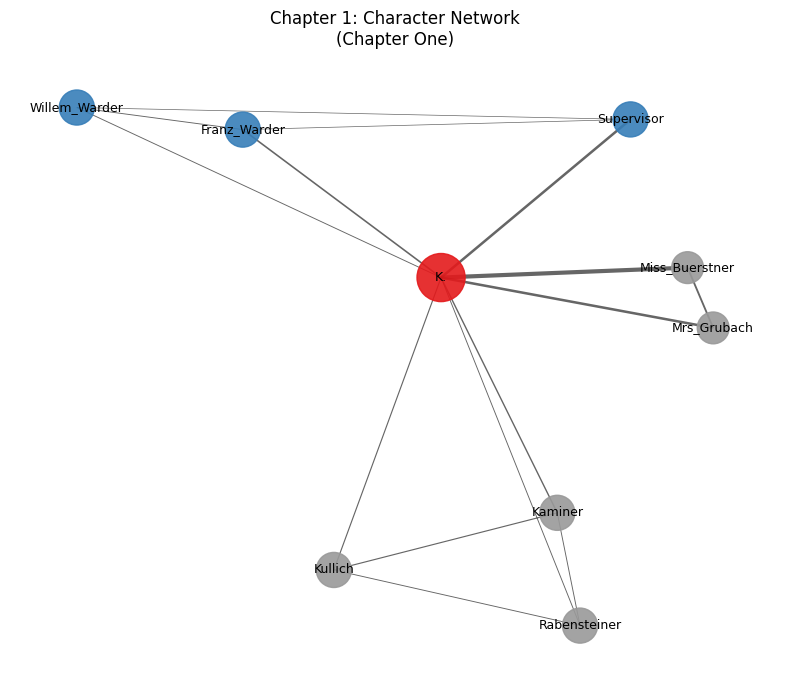

Saved out/fig_network_ch01.png


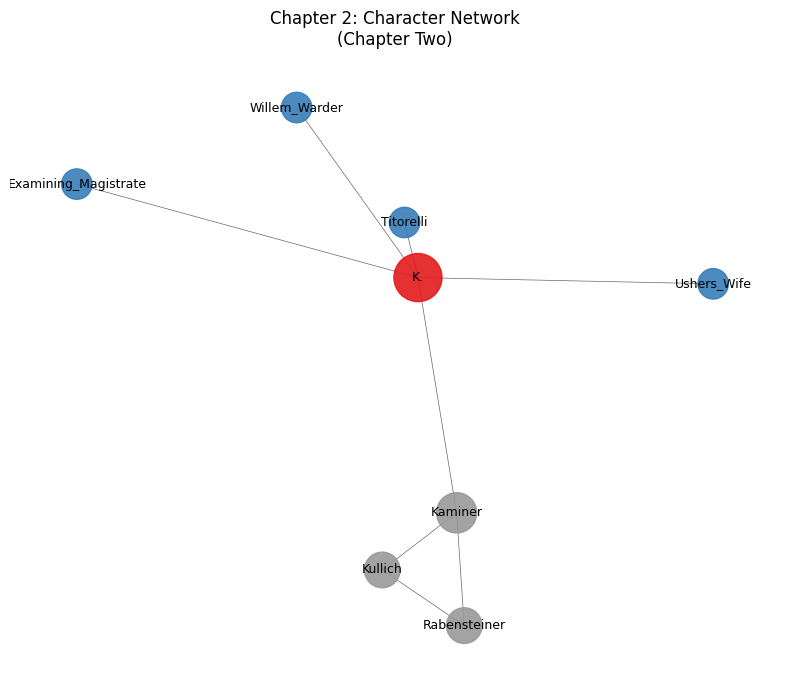

Saved out/fig_network_ch02.png


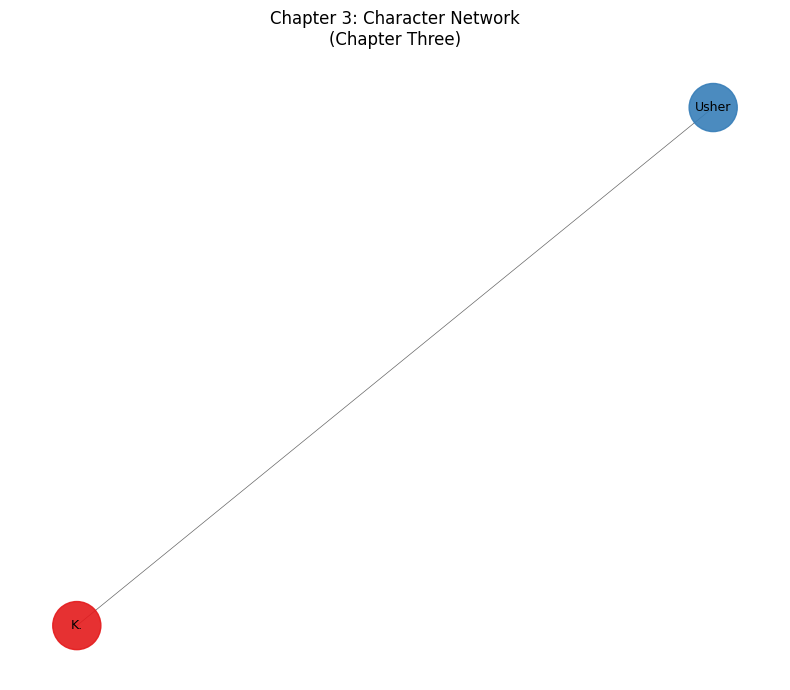

Saved out/fig_network_ch03.png


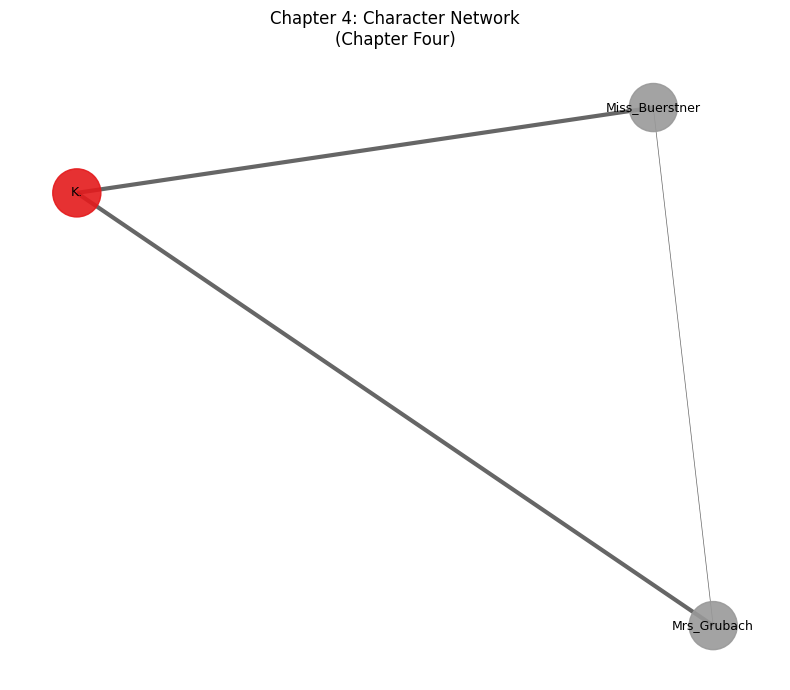

Saved out/fig_network_ch04.png


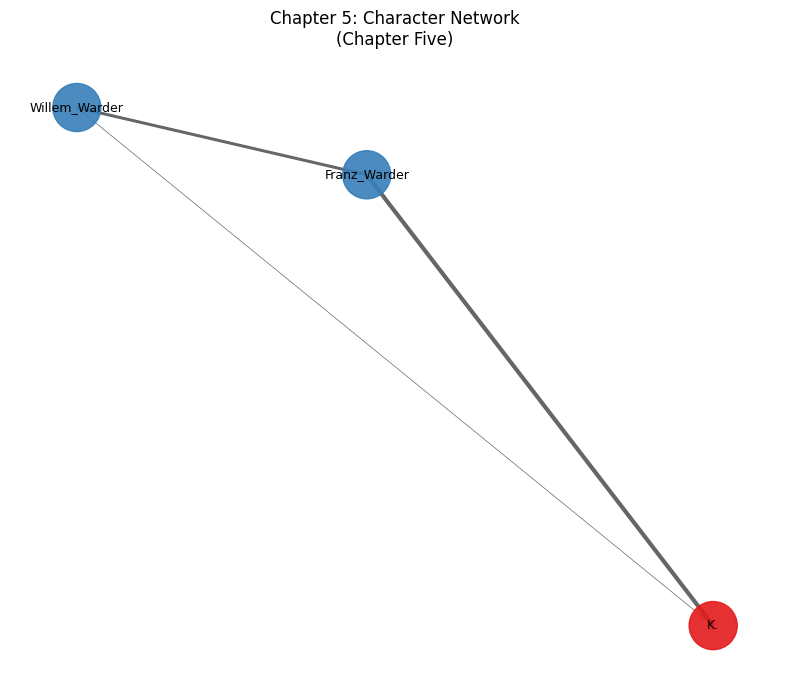

Saved out/fig_network_ch05.png


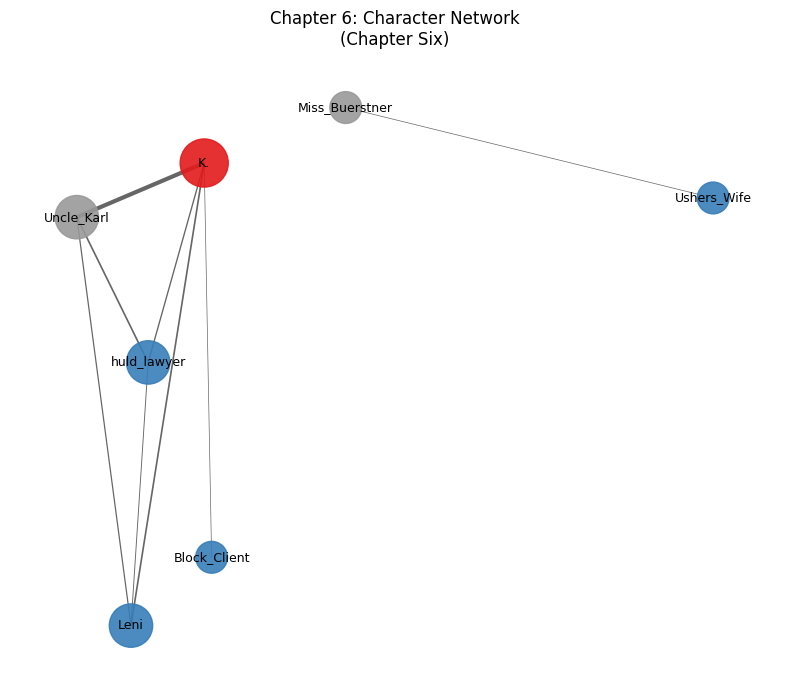

Saved out/fig_network_ch06.png


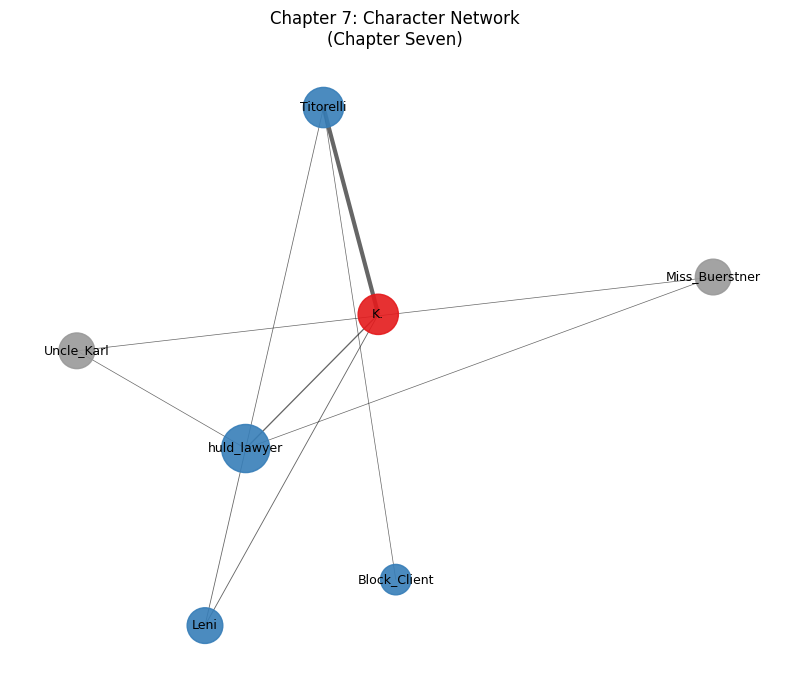

Saved out/fig_network_ch07.png


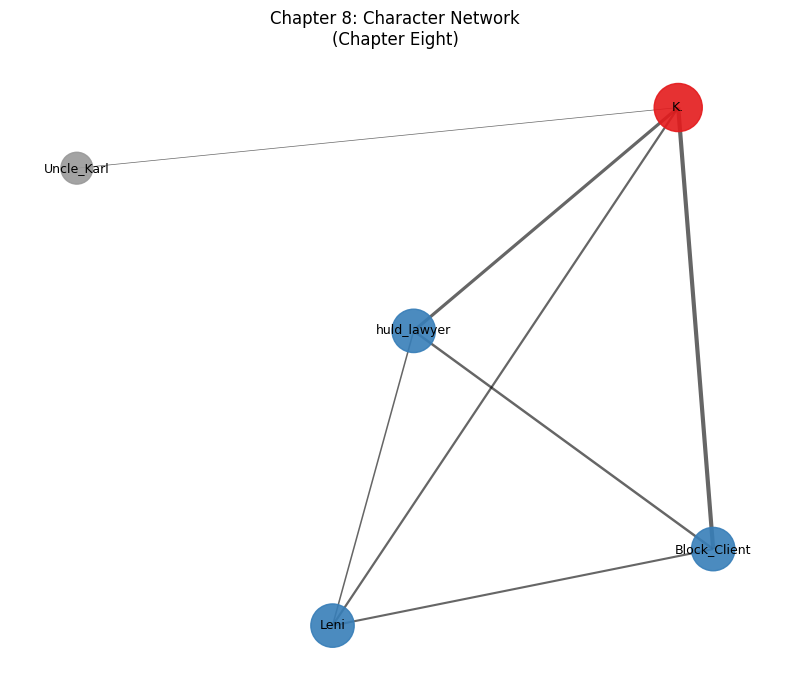

Saved out/fig_network_ch08.png


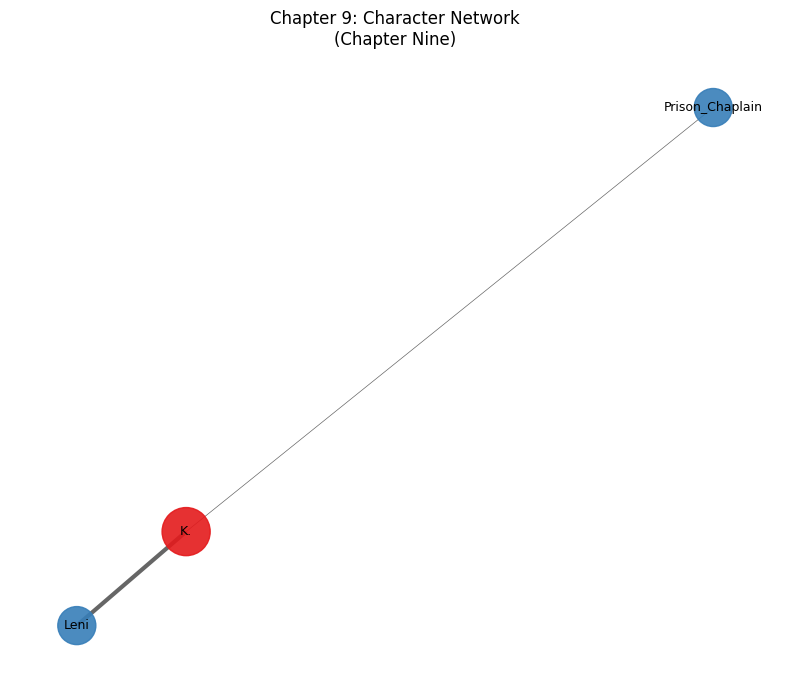

Saved out/fig_network_ch09.png


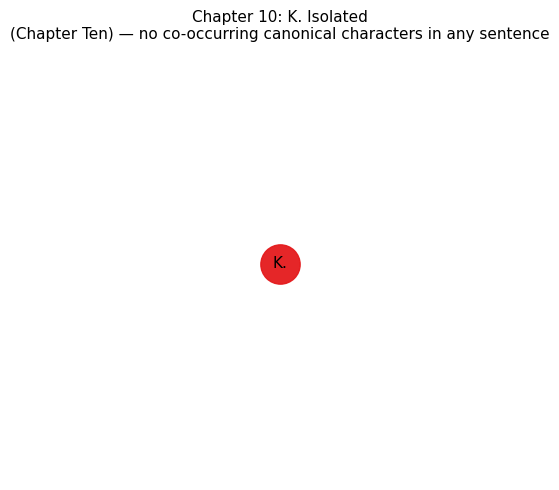

Saved isolated-view network for Chapter 10: out/fig_network_ch10_isolated.png


In [78]:
# Use the chapters from df_sents (they exist even if no edges)
all_chapters = sorted(df_sents["chapter"].unique())

for ch in all_chapters:
    draw_chapter_network(chapter_num=ch, min_weight=1)


K.’s distinct neighbors per chapter:
   chapter  k_neighbors
0        1            8
1        2            5
2        3            1
3        4            2
4        5            2
5        6            4
6        7            3
7        8            4
8        9            2


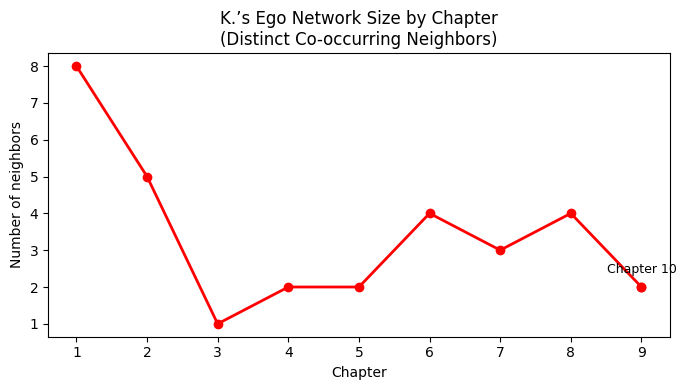

Wrote: /Users/shikha/Desktop/MTL RESEARCH/out/fig_k_neighbors_by_chapter.png


In [39]:
# ==========================
# K.’s isolation in ONE plot:
# Distinct neighbors of K per chapter
# ==========================
import itertools
import pandas as pd
import matplotlib.pyplot as plt

K_LABEL = "K."   # your canonical label for Josef K.

# 1) Build chapter-wise co-occurrence edges from char_sents
#    (each sentence: all pairs of co-occurring characters)
edge_rows = []

for (ch, ch_title, sid), group in char_sents.groupby(["chapter", "chapter_title", "sent_id"]):
    chars = sorted(group["character"].unique())
    if len(chars) < 2:
        continue
    for a, b in itertools.combinations(chars, 2):
        edge_rows.append((ch, ch_title, a, b))

edges_df = pd.DataFrame(edge_rows, columns=["chapter", "chapter_title", "source", "target"])

# Optional: collapse duplicates into weighted edges
edges_weighted = (
    edges_df
    .groupby(["chapter", "source", "target"])
    .size()
    .reset_index(name="weight")
)

# 2) Filter edges that touch K and extract the "other" node
k_edges = edges_weighted[
    (edges_weighted["source"] == K_LABEL) | (edges_weighted["target"] == K_LABEL)
].copy()

if k_edges.empty:
    print("No edges involving K. found – check K_LABEL or name normalization.")
else:
    k_edges["neighbor"] = k_edges.apply(
        lambda r: r["target"] if r["source"] == K_LABEL else r["source"],
        axis=1
    )

    # 3) Count distinct neighbors per chapter
    deg_K = (
        k_edges.groupby("chapter")["neighbor"]
        .nunique()
        .reset_index(name="k_neighbors")
        .sort_values("chapter")
    )

    print("\nK.’s distinct neighbors per chapter:")
    print(deg_K)

    # 4) Plot: ONE line that shows K’s social contraction
    plt.figure(figsize=(7, 4))
    plt.plot(
        deg_K["chapter"],
        deg_K["k_neighbors"],
        marker="o",
        linewidth=2,
        color="red"
    )

    # Annotate chapter 10 (or last chapter) explicitly
    last_row = deg_K.iloc[-1]
    plt.scatter(last_row["chapter"], last_row["k_neighbors"], color="red")
    plt.text(
        last_row["chapter"],
        last_row["k_neighbors"] + 0.3,
        "Chapter 10",
        ha="center",
        va="bottom",
        fontsize=9
    )

    plt.title("K.’s Ego Network Size by Chapter\n(Distinct Co-occurring Neighbors)")
    plt.xlabel("Chapter")
    plt.ylabel("Number of neighbors")
    plt.xticks(deg_K["chapter"])
    plt.tight_layout()

    out_fig = OUT / "fig_k_neighbors_by_chapter.png"
    plt.savefig(out_fig, dpi=200)
    plt.show()
    print("Wrote:", out_fig.resolve())

Guilty usage by chapter:
   chapter  guilty_count  tokens  guilty_per_1000
0        1             2   10847         0.184383
1        2             0    6353         0.000000
2        3             0    9366         0.000000
3        4             0    2820         0.000000
4        5             1    2668         0.374813
5        6             0    7958         0.000000
6        7             1   19348         0.051685
7        8             2   11325         0.176600
8        9             6    9038         0.663864
9       10             0    2060         0.000000
Wrote: /Users/shikha/Desktop/MTL RESEARCH/out/guilty_by_chapter.csv


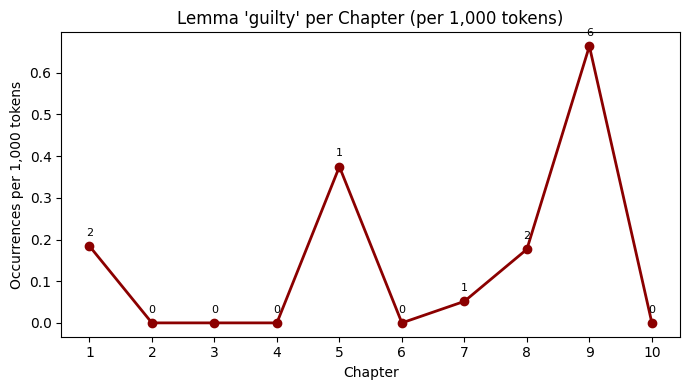

Wrote: /Users/shikha/Desktop/MTL RESEARCH/out/fig_guilty_per_chapter.png


In [40]:
# =========================================
# "guilty" over the ten chapters
# =========================================
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Ensure chapters are in sorted order
chapters = sorted(TOKENS["chapter"].unique())

# 1) Raw counts of lemma "guilty" per chapter
guilty_counts = (
    TOKENS[TOKENS["lemma_l"] == "guilty"]
    .groupby("chapter")
    .size()
    .reindex(chapters, fill_value=0)
)

# 2) Tokens per chapter (for normalization)
tokens_per_ch = (
    TOKENS
    .groupby("chapter")
    .size()
    .reindex(chapters)
)

# 3) Normalize: occurrences per 1,000 tokens
guilty_per1k = (guilty_counts / tokens_per_ch) * 1000

# 4) Make a small summary table and save
guilty_df = pd.DataFrame({
    "chapter": chapters,
    "guilty_count": guilty_counts.values,
    "tokens": tokens_per_ch.values,
    "guilty_per_1000": guilty_per1k.values,
})

print("Guilty usage by chapter:")
print(guilty_df)

out_csv = OUT / "guilty_by_chapter.csv"
guilty_df.to_csv(out_csv, index=False)
print("Wrote:", out_csv.resolve())

# 5) Plot: "guilty" per 1,000 tokens across chapters
plt.figure(figsize=(7, 4))
plt.plot(
    guilty_df["chapter"],
    guilty_df["guilty_per_1000"],
    marker="o",
    linewidth=2,
    color="darkred",
)

# Annotate points with raw counts for readability
for _, row in guilty_df.iterrows():
    plt.text(
        row["chapter"],
        row["guilty_per_1000"] + max(guilty_df["guilty_per_1000"]) * 0.03 if guilty_df["guilty_per_1000"].max() > 0 else 0.05,
        str(int(row["guilty_count"])),
        ha="center",
        va="bottom",
        fontsize=8,
    )

plt.title("Lemma 'guilty' per Chapter (per 1,000 tokens)")
plt.xlabel("Chapter")
plt.ylabel("Occurrences per 1,000 tokens")
plt.xticks(guilty_df["chapter"])
plt.tight_layout()

out_fig = OUT / "fig_guilty_per_chapter.png"
plt.savefig(out_fig, dpi=200)
plt.show()
print("Wrote:", out_fig.resolve())

Combined K-ego + 'guilty' table:
   chapter  k_neighbors  guilty_per_1000
0        1          8.0         0.184383
1        2          5.0         0.000000
2        3          1.0         0.000000
3        4          2.0         0.000000
4        5          2.0         0.374813
5        6          4.0         0.000000
6        7          3.0         0.051685
7        8          4.0         0.176600
8        9          2.0         0.663864
9       10          0.0         0.000000


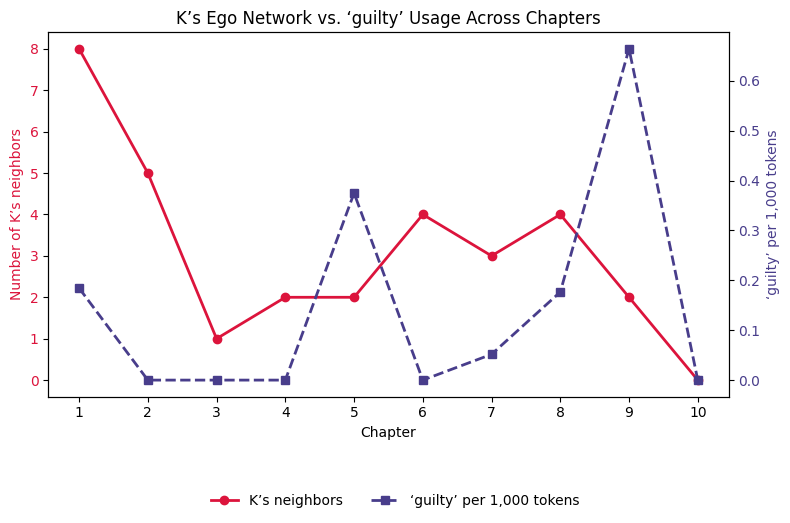

Wrote: /Users/shikha/Desktop/MTL RESEARCH/out/fig_k_ego_and_guilty_combined.png


In [43]:
import matplotlib.pyplot as plt
import pandas as pd

# Merge with outer join so we keep chapter 10
combo = pd.merge(
    deg_K[["chapter", "k_neighbors"]],
    guilty_df[["chapter", "guilty_per_1000"]],
    on="chapter",
    how="outer"
).sort_values("chapter")

# If K has no row for a chapter, treat that as 0 neighbors
combo["k_neighbors"] = combo["k_neighbors"].fillna(0)

# If 'guilty' doesn't appear in some chapter, treat as 0 per 1k
combo["guilty_per_1000"] = combo["guilty_per_1000"].fillna(0)

print("Combined K-ego + 'guilty' table:")
print(combo)

fig, ax1 = plt.subplots(figsize=(8, 5))

# ---- Left axis: K’s neighbors ----
color_ego = "crimson"
ln1 = ax1.plot(
    combo["chapter"],
    combo["k_neighbors"],
    marker="o",
    linewidth=2,
    color=color_ego,
    label="K’s neighbors"
)
ax1.set_xlabel("Chapter")
ax1.set_ylabel("Number of K’s neighbors", color=color_ego)
ax1.tick_params(axis="y", labelcolor=color_ego)
ax1.set_xticks(combo["chapter"])

# ---- Right axis: 'guilty' per 1,000 tokens ----
ax2 = ax1.twinx()
color_guilt = "darkslateblue"
ln2 = ax2.plot(
    combo["chapter"],
    combo["guilty_per_1000"],
    marker="s",
    linewidth=2,
    linestyle="--",
    color=color_guilt,
    label="‘guilty’ per 1,000 tokens"
)
ax2.set_ylabel("‘guilty’ per 1,000 tokens", color=color_guilt)
ax2.tick_params(axis="y", labelcolor=color_guilt)

# ---- Legend below the plot ----
lines = ln1 + ln2
labels = [l.get_label() for l in lines]
fig.legend(
    lines,
    labels,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.05),
    ncol=2,
    frameon=False
)

plt.title("K’s Ego Network vs. ‘guilty’ Usage Across Chapters")

# Leave space at bottom for legend
fig.tight_layout(rect=(0, 0.08, 1, 1))

out_fig = OUT / "fig_k_ego_and_guilty_combined.png"
plt.savefig(out_fig, dpi=200)
plt.show()
print("Wrote:", out_fig.resolve())